# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.callbacks import classification_acc
from vbranch.applications.fcn import FCN
from vbranch.applications.cnn import CNN
from vbranch.losses import softmax_cross_entropy_with_logits

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import get_data, bag_samples, get_data_iterator
from vbranch.utils.generic import get_path, save_results

Using TensorFlow backend.


In [3]:
MODEL_ID = 1
ARCHITECTURE = 'cnn'
DATASET = 'cifar10'
NUM_CLASSES = 10
NUM_FEATURES = None
SAMPLES_PER_CLASS = None
BAGGING_SAMPLES = 1.
TRAIN_FRAC = 1.

BATCH_SIZE = 64
EPOCHS = 50
STEPS_PER_EPOCH = 100

## Data

In [4]:
(X_train, y_train), (X_test, y_test) = get_data(DATASET, ARCHITECTURE, NUM_CLASSES,
                                                NUM_FEATURES, SAMPLES_PER_CLASS, 
                                                train_frac=TRAIN_FRAC, preprocess=True)
x_shape = (None,) + X_train.shape[1:]
y_shape = (None, NUM_CLASSES)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [6]:
print(X_train.min(), X_train.max())

-1.0 1.0


## Training

In [7]:
def path(n_branches, shared_frac):
    return get_path(DATASET, ARCHITECTURE, 'sensitivity-Ba64', vb=True, 
                    B=n_branches, S=shared_frac)

In [8]:
def build_model(n_branches, shared_frac, name='model', compile_loss=True):
    inputs, labels, train_init_op, test_init_op = get_data_iterator(x_shape, y_shape, 
                                                                    batch_size=BATCH_SIZE, 
                                                                    n=n_branches, 
                                                                    share_xy=BAGGING_SAMPLES == 0)
#     with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
#         if ARCHITECTURE == 'fcn':
#             layer_spec = [(512, shared_frac), NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn2':
#             layer_spec = [(512, shared_frac), 512, NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn3':
#             layer_spec = [(512, shared_frac), 512, 512, NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn2A':
#             layer_spec = [(512, shared_frac), (512, shared_frac), (NUM_CLASSES, shared_frac)]
#         elif ARCHITECTURE == 'fcn3A':
#             layer_spec = [(512, shared_frac), (512, shared_frac), 
#                           (512, shared_frac), (NUM_CLASSES, shared_frac)]
#         else:
#             raise ValueError('invalid model')
            
#         model = FCN(inputs, *layer_spec, name=name, shared_frac=1)

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        if ARCHITECTURE == 'cnn':
            layers = [32, 64, 128]
        elif ARCHITECTURE == 'cnnx':
            layers = [(32, shared_frac), (64, 1.0), (128, 1.0)]
        else:
            raise ValueError('invalid model')
        model = CNN(inputs, NUM_CLASSES, *layers, name=name, shared_frac=shared_frac)
        
        if compile_loss:
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
            model.compile(optimizer, softmax_cross_entropy_with_logits(), 
                          train_init_op, test_init_op, labels=labels, 
                          callbacks={'acc':classification_acc(n_branches)})

    return model

In [9]:
def train(n_branches, shared_frac, model_id=1):
    dirpath = path(n_branches, shared_frac)
    model_path = os.path.join('models', dirpath, 'model_{}'.format(model_id))
    os.system('mkdir -p ' + model_path)
    print(model_path)
    
    tf.reset_default_graph()
    model = build_model(n_branches, shared_frac)
    model.summary()
    
    # Bagging
    if BAGGING_SAMPLES > 0:
        x_train_list, y_train_list = bag_samples(X_train, y_train, n_branches, 
                                                 max_samples=BAGGING_SAMPLES)

    if n_branches == 1 or BAGGING_SAMPLES == 0:
        train_dict = {'x:0': X_train, 'y:0': y_train, 'batch_size:0': BATCH_SIZE}
    else:
        train_dict = {'x:0': X_train, 'y:0': y_train}
        for i in range(n_branches):
            train_dict['vb{}_x:0'.format(i+1)] = x_train_list[i]
            train_dict['vb{}_y:0'.format(i+1)] = y_train_list[i]
        train_dict['batch_size:0'] = BATCH_SIZE

    val_dict = {'x:0': X_test, 'y:0': y_test, 'batch_size:0': len(X_test)}

    history = model.fit(EPOCHS, STEPS_PER_EPOCH, train_dict=train_dict,
                        val_dict=val_dict, log_path=model_path)
    save_results(history, dirpath, 'train_{}.csv'.format(model_id))
    
    return history

In [ ]:
for n_branches in range(2, 5):
    for shared_frac in [0., 0.25, 0.5, 0.75, 1.]:
        for t in range(4):
            train(n_branches, shared_frac, model_id=t+1)
# history = train(n_branches=1, shared_frac=None)

W0804 12:14:34.166461 140571476088576 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:134: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 12:14:34.197612 140571476088576 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:156: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.

W0804 12:14:34.203207 140571476088576 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:348: Iterator.output_types (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
W0804 12:14:34.203778 140571476088576 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:349: Iterator.output_shapes (from tensorflow.pyt

models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.00/model_1


W0804 12:14:34.607282 140571476088576 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/layers/core.py:83: The name tf.nn.xw_plus_b is deprecated. Please use tf.compat.v1.nn.xw_plus_b instead.

W0804 12:14:34.699779 140571476088576 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/engine/training.py:127: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.



i   Layer name                      Output shape        Num param  Inbound            
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [] [None,32,32,32]  1792       input              
                                    [] [None,32,32,32]                                
--------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [] [None,32,32,32]  128        conv2d_1_1         
                                    [] [None,32,32,32]                                
-------------------------------------------

100/100 - 6s - loss_1: 1.0551 - loss_2: 1.0705 - acc_ensemble: 0.6920 - acc_1: 0.6440 - acc_2: 0.6620 - val_loss_1: 1.0465 - val_loss_2: 1.0321 - val_acc_ensemble: 0.6557 - val_acc_1: 0.6234 - val_acc_2: 0.6309
Epoch 7/50
100/100 - 6s - loss_1: 1.0091 - loss_2: 0.9894 - acc_ensemble: 0.7000 - acc_1: 0.6580 - acc_2: 0.6580 - val_loss_1: 0.9679 - val_loss_2: 0.9703 - val_acc_ensemble: 0.6771 - val_acc_1: 0.6513 - val_acc_2: 0.6510
Epoch 8/50
100/100 - 6s - loss_1: 0.9224 - loss_2: 0.9412 - acc_ensemble: 0.7120 - acc_1: 0.6440 - acc_2: 0.6960 - val_loss_1: 0.9648 - val_loss_2: 0.9554 - val_acc_ensemble: 0.6866 - val_acc_1: 0.6523 - val_acc_2: 0.6558
Epoch 9/50
100/100 - 6s - loss_1: 0.8611 - loss_2: 0.9112 - acc_ensemble: 0.7200 - acc_1: 0.6860 - acc_2: 0.6700 - val_loss_1: 0.9452 - val_loss_2: 0.9141 - val_acc_ensemble: 0.7012 - val_acc_1: 0.6618 - val_acc_2: 0.6661
Epoch 10/50
100/100 - 6s - loss_1: 0.8257 - loss_2: 0.8553 - acc_ensemble: 0.7340 - acc_1: 0.7160 - acc_2: 0.7040 - val_los

Epoch 43/50
100/100 - 6s - loss_1: 0.1568 - loss_2: 0.1518 - acc_ensemble: 0.9000 - acc_1: 0.8540 - acc_2: 0.8760 - val_loss_1: 0.7390 - val_loss_2: 0.7226 - val_acc_ensemble: 0.8221 - val_acc_1: 0.7854 - val_acc_2: 0.7885
Epoch 44/50
100/100 - 6s - loss_1: 0.1368 - loss_2: 0.1429 - acc_ensemble: 0.9100 - acc_1: 0.8680 - acc_2: 0.8560 - val_loss_1: 0.7434 - val_loss_2: 0.7818 - val_acc_ensemble: 0.8190 - val_acc_1: 0.7874 - val_acc_2: 0.7757
Epoch 45/50
100/100 - 6s - loss_1: 0.1381 - loss_2: 0.1446 - acc_ensemble: 0.9220 - acc_1: 0.8600 - acc_2: 0.8820 - val_loss_1: 0.7621 - val_loss_2: 0.7410 - val_acc_ensemble: 0.8227 - val_acc_1: 0.7874 - val_acc_2: 0.7895
Epoch 46/50
100/100 - 6s - loss_1: 0.1148 - loss_2: 0.1367 - acc_ensemble: 0.9000 - acc_1: 0.8500 - acc_2: 0.8740 - val_loss_1: 0.8297 - val_loss_2: 0.7746 - val_acc_ensemble: 0.8182 - val_acc_1: 0.7764 - val_acc_2: 0.7832
Epoch 47/50
100/100 - 6s - loss_1: 0.1452 - loss_2: 0.1446 - acc_ensemble: 0.9220 - acc_1: 0.8660 - acc_2: 0

W0804 12:19:50.046411 140571476088576 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/engine/training.py:265: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.00/model_2
i   Layer name                      Output shape        Num param  Inbound            
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [] [None,32,32,32]  1792       input              
                                    [] [None,32,32,32]                                
--------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [] [None,32,32,32]  128        conv2d_1_1         
                                    [] [None,32,32,32]                    

Epoch 6/50
100/100 - 6s - loss_1: 1.0187 - loss_2: 1.0483 - acc_ensemble: 0.6860 - acc_1: 0.6480 - acc_2: 0.6260 - val_loss_1: 1.0042 - val_loss_2: 1.0691 - val_acc_ensemble: 0.6635 - val_acc_1: 0.6415 - val_acc_2: 0.6114
Epoch 7/50
100/100 - 6s - loss_1: 0.9338 - loss_2: 1.0146 - acc_ensemble: 0.7080 - acc_1: 0.6720 - acc_2: 0.6260 - val_loss_1: 0.9760 - val_loss_2: 1.0035 - val_acc_ensemble: 0.6820 - val_acc_1: 0.6518 - val_acc_2: 0.6415
Epoch 8/50
100/100 - 6s - loss_1: 0.8906 - loss_2: 0.9329 - acc_ensemble: 0.7240 - acc_1: 0.6780 - acc_2: 0.6860 - val_loss_1: 0.9294 - val_loss_2: 0.9784 - val_acc_ensemble: 0.6927 - val_acc_1: 0.6694 - val_acc_2: 0.6499
Epoch 9/50
100/100 - 6s - loss_1: 0.8287 - loss_2: 0.9051 - acc_ensemble: 0.7280 - acc_1: 0.6840 - acc_2: 0.6880 - val_loss_1: 0.9237 - val_loss_2: 0.9347 - val_acc_ensemble: 0.6965 - val_acc_1: 0.6686 - val_acc_2: 0.6650
Epoch 10/50
100/100 - 6s - loss_1: 0.8275 - loss_2: 0.8615 - acc_ensemble: 0.7420 - acc_1: 0.7300 - acc_2: 0.678

Epoch 43/50
100/100 - 6s - loss_1: 0.1722 - loss_2: 0.1751 - acc_ensemble: 0.8980 - acc_1: 0.8620 - acc_2: 0.8820 - val_loss_1: 0.7447 - val_loss_2: 0.7365 - val_acc_ensemble: 0.8231 - val_acc_1: 0.7881 - val_acc_2: 0.7795
Epoch 44/50
100/100 - 6s - loss_1: 0.1761 - loss_2: 0.1590 - acc_ensemble: 0.8960 - acc_1: 0.8540 - acc_2: 0.8720 - val_loss_1: 0.8122 - val_loss_2: 0.7965 - val_acc_ensemble: 0.8170 - val_acc_1: 0.7754 - val_acc_2: 0.7702
Epoch 45/50
100/100 - 6s - loss_1: 0.1561 - loss_2: 0.1748 - acc_ensemble: 0.9220 - acc_1: 0.8640 - acc_2: 0.8920 - val_loss_1: 0.7945 - val_loss_2: 0.7665 - val_acc_ensemble: 0.8230 - val_acc_1: 0.7771 - val_acc_2: 0.7791
Epoch 46/50
100/100 - 6s - loss_1: 0.1323 - loss_2: 0.1334 - acc_ensemble: 0.9080 - acc_1: 0.8740 - acc_2: 0.8800 - val_loss_1: 0.7392 - val_loss_2: 0.7820 - val_acc_ensemble: 0.8249 - val_acc_1: 0.7945 - val_acc_2: 0.7806
Epoch 47/50
100/100 - 6s - loss_1: 0.1370 - loss_2: 0.1262 - acc_ensemble: 0.9200 - acc_1: 0.8740 - acc_2: 0

Epoch 1/50
100/100 - 7s - loss_1: 1.7969 - loss_2: 1.7664 - acc_ensemble: 0.4820 - acc_1: 0.4560 - acc_2: 0.4380 - val_loss_1: 1.5243 - val_loss_2: 1.5437 - val_acc_ensemble: 0.4648 - val_acc_1: 0.4336 - val_acc_2: 0.4332
Epoch 2/50
100/100 - 6s - loss_1: 1.4949 - loss_2: 1.4910 - acc_ensemble: 0.5480 - acc_1: 0.5100 - acc_2: 0.4960 - val_loss_1: 1.3940 - val_loss_2: 1.4310 - val_acc_ensemble: 0.5126 - val_acc_1: 0.4882 - val_acc_2: 0.4709
Epoch 3/50
100/100 - 6s - loss_1: 1.3891 - loss_2: 1.3181 - acc_ensemble: 0.5780 - acc_1: 0.5440 - acc_2: 0.5680 - val_loss_1: 1.2926 - val_loss_2: 1.2419 - val_acc_ensemble: 0.5778 - val_acc_1: 0.5240 - val_acc_2: 0.5475
Epoch 4/50
100/100 - 6s - loss_1: 1.2524 - loss_2: 1.2072 - acc_ensemble: 0.6160 - acc_1: 0.5760 - acc_2: 0.5880 - val_loss_1: 1.2337 - val_loss_2: 1.1562 - val_acc_ensemble: 0.5976 - val_acc_1: 0.5465 - val_acc_2: 0.5861
Epoch 5/50
100/100 - 6s - loss_1: 1.1603 - loss_2: 1.1159 - acc_ensemble: 0.6600 - acc_1: 0.6140 - acc_2: 0.6200

Epoch 38/50
100/100 - 6s - loss_1: 0.1876 - loss_2: 0.2176 - acc_ensemble: 0.9020 - acc_1: 0.8540 - acc_2: 0.8640 - val_loss_1: 0.7007 - val_loss_2: 0.6854 - val_acc_ensemble: 0.8282 - val_acc_1: 0.7894 - val_acc_2: 0.7875
Epoch 39/50
100/100 - 6s - loss_1: 0.1890 - loss_2: 0.1918 - acc_ensemble: 0.8940 - acc_1: 0.8380 - acc_2: 0.8580 - val_loss_1: 0.7311 - val_loss_2: 0.7221 - val_acc_ensemble: 0.8220 - val_acc_1: 0.7829 - val_acc_2: 0.7856
Epoch 40/50
100/100 - 6s - loss_1: 0.1992 - loss_2: 0.1904 - acc_ensemble: 0.9120 - acc_1: 0.8700 - acc_2: 0.8760 - val_loss_1: 0.7152 - val_loss_2: 0.7083 - val_acc_ensemble: 0.8236 - val_acc_1: 0.7869 - val_acc_2: 0.7861
Epoch 41/50
100/100 - 6s - loss_1: 0.1702 - loss_2: 0.1666 - acc_ensemble: 0.9140 - acc_1: 0.8680 - acc_2: 0.8780 - val_loss_1: 0.7231 - val_loss_2: 0.7103 - val_acc_ensemble: 0.8281 - val_acc_1: 0.7917 - val_acc_2: 0.7946
Epoch 42/50
100/100 - 6s - loss_1: 0.1459 - loss_2: 0.1525 - acc_ensemble: 0.9000 - acc_1: 0.8600 - acc_2: 0

Epoch 1/50
100/100 - 7s - loss_1: 1.8151 - loss_2: 1.8203 - acc_ensemble: 0.4420 - acc_1: 0.4100 - acc_2: 0.4120 - val_loss_1: 1.6065 - val_loss_2: 1.5750 - val_acc_ensemble: 0.4331 - val_acc_1: 0.4101 - val_acc_2: 0.4116
Epoch 2/50
100/100 - 6s - loss_1: 1.5239 - loss_2: 1.5125 - acc_ensemble: 0.5000 - acc_1: 0.4960 - acc_2: 0.4740 - val_loss_1: 1.4445 - val_loss_2: 1.4423 - val_acc_ensemble: 0.5015 - val_acc_1: 0.4680 - val_acc_2: 0.4674
Epoch 3/50
100/100 - 6s - loss_1: 1.3559 - loss_2: 1.3797 - acc_ensemble: 0.5680 - acc_1: 0.5520 - acc_2: 0.5000 - val_loss_1: 1.2785 - val_loss_2: 1.3450 - val_acc_ensemble: 0.5649 - val_acc_1: 0.5294 - val_acc_2: 0.5077
Epoch 4/50
100/100 - 6s - loss_1: 1.2089 - loss_2: 1.2717 - acc_ensemble: 0.6360 - acc_1: 0.5960 - acc_2: 0.5760 - val_loss_1: 1.1634 - val_loss_2: 1.2121 - val_acc_ensemble: 0.6055 - val_acc_1: 0.5806 - val_acc_2: 0.5573
Epoch 5/50
100/100 - 6s - loss_1: 1.1294 - loss_2: 1.1519 - acc_ensemble: 0.6680 - acc_1: 0.6180 - acc_2: 0.6240

Epoch 38/50
100/100 - 6s - loss_1: 0.2159 - loss_2: 0.2200 - acc_ensemble: 0.8840 - acc_1: 0.8540 - acc_2: 0.8500 - val_loss_1: 0.7251 - val_loss_2: 0.7691 - val_acc_ensemble: 0.8150 - val_acc_1: 0.7828 - val_acc_2: 0.7754
Epoch 39/50
100/100 - 6s - loss_1: 0.1943 - loss_2: 0.2326 - acc_ensemble: 0.8940 - acc_1: 0.8300 - acc_2: 0.8560 - val_loss_1: 0.7484 - val_loss_2: 0.7167 - val_acc_ensemble: 0.8204 - val_acc_1: 0.7720 - val_acc_2: 0.7832
Epoch 40/50
100/100 - 6s - loss_1: 0.1890 - loss_2: 0.1848 - acc_ensemble: 0.8900 - acc_1: 0.8340 - acc_2: 0.8660 - val_loss_1: 0.7496 - val_loss_2: 0.7426 - val_acc_ensemble: 0.8252 - val_acc_1: 0.7853 - val_acc_2: 0.7846
Epoch 41/50
100/100 - 6s - loss_1: 0.1748 - loss_2: 0.1947 - acc_ensemble: 0.9040 - acc_1: 0.8700 - acc_2: 0.8720 - val_loss_1: 0.7389 - val_loss_2: 0.7481 - val_acc_ensemble: 0.8208 - val_acc_1: 0.7851 - val_acc_2: 0.7819
Epoch 42/50
100/100 - 6s - loss_1: 0.1659 - loss_2: 0.1731 - acc_ensemble: 0.9180 - acc_1: 0.8580 - acc_2: 0

Epoch 1/50
100/100 - 17s - loss_1: 1.7849 - loss_2: 1.7734 - acc_ensemble: 0.4600 - acc_1: 0.4460 - acc_2: 0.4440 - val_loss_1: 1.5329 - val_loss_2: 1.5272 - val_acc_ensemble: 0.4589 - val_acc_1: 0.4331 - val_acc_2: 0.4291
Epoch 2/50
100/100 - 9s - loss_1: 1.4674 - loss_2: 1.4367 - acc_ensemble: 0.5380 - acc_1: 0.5200 - acc_2: 0.5040 - val_loss_1: 1.3516 - val_loss_2: 1.3606 - val_acc_ensemble: 0.5315 - val_acc_1: 0.5092 - val_acc_2: 0.5018
Epoch 3/50
100/100 - 9s - loss_1: 1.3053 - loss_2: 1.3036 - acc_ensemble: 0.5960 - acc_1: 0.5640 - acc_2: 0.5520 - val_loss_1: 1.2559 - val_loss_2: 1.2167 - val_acc_ensemble: 0.5873 - val_acc_1: 0.5464 - val_acc_2: 0.5684
Epoch 4/50
100/100 - 9s - loss_1: 1.1681 - loss_2: 1.1862 - acc_ensemble: 0.6380 - acc_1: 0.5960 - acc_2: 0.6000 - val_loss_1: 1.1642 - val_loss_2: 1.1745 - val_acc_ensemble: 0.6095 - val_acc_1: 0.5764 - val_acc_2: 0.5719
Epoch 5/50
100/100 - 9s - loss_1: 1.1023 - loss_2: 1.0581 - acc_ensemble: 0.6500 - acc_1: 0.5820 - acc_2: 0.642

Epoch 38/50
100/100 - 9s - loss_1: 0.1221 - loss_2: 0.1379 - acc_ensemble: 0.9000 - acc_1: 0.8320 - acc_2: 0.8660 - val_loss_1: 0.8914 - val_loss_2: 0.8389 - val_acc_ensemble: 0.8022 - val_acc_1: 0.7568 - val_acc_2: 0.7679
Epoch 39/50
100/100 - 9s - loss_1: 0.1384 - loss_2: 0.1328 - acc_ensemble: 0.9180 - acc_1: 0.8480 - acc_2: 0.8700 - val_loss_1: 0.9120 - val_loss_2: 0.8379 - val_acc_ensemble: 0.8018 - val_acc_1: 0.7548 - val_acc_2: 0.7686
Epoch 40/50
100/100 - 9s - loss_1: 0.1148 - loss_2: 0.1014 - acc_ensemble: 0.9180 - acc_1: 0.8500 - acc_2: 0.8680 - val_loss_1: 0.9196 - val_loss_2: 0.8617 - val_acc_ensemble: 0.8026 - val_acc_1: 0.7537 - val_acc_2: 0.7677
Epoch 41/50
100/100 - 9s - loss_1: 0.1366 - loss_2: 0.0786 - acc_ensemble: 0.9020 - acc_1: 0.8480 - acc_2: 0.8660 - val_loss_1: 0.9231 - val_loss_2: 0.8980 - val_acc_ensemble: 0.8006 - val_acc_1: 0.7514 - val_acc_2: 0.7635
Epoch 42/50
100/100 - 9s - loss_1: 0.1203 - loss_2: 0.0874 - acc_ensemble: 0.9040 - acc_1: 0.8420 - acc_2: 0

Epoch 1/50
100/100 - 13s - loss_1: 1.7883 - loss_2: 1.7662 - acc_ensemble: 0.4520 - acc_1: 0.4160 - acc_2: 0.4180 - val_loss_1: 1.5416 - val_loss_2: 1.5466 - val_acc_ensemble: 0.4564 - val_acc_1: 0.4227 - val_acc_2: 0.4240
Epoch 2/50
100/100 - 9s - loss_1: 1.4838 - loss_2: 1.4601 - acc_ensemble: 0.5340 - acc_1: 0.5040 - acc_2: 0.5300 - val_loss_1: 1.3546 - val_loss_2: 1.3906 - val_acc_ensemble: 0.5257 - val_acc_1: 0.4894 - val_acc_2: 0.4863
Epoch 3/50
100/100 - 9s - loss_1: 1.3070 - loss_2: 1.2982 - acc_ensemble: 0.6100 - acc_1: 0.5920 - acc_2: 0.5640 - val_loss_1: 1.2581 - val_loss_2: 1.2101 - val_acc_ensemble: 0.5904 - val_acc_1: 0.5400 - val_acc_2: 0.5590
Epoch 4/50
100/100 - 9s - loss_1: 1.1963 - loss_2: 1.1435 - acc_ensemble: 0.6420 - acc_1: 0.5740 - acc_2: 0.6240 - val_loss_1: 1.1713 - val_loss_2: 1.1320 - val_acc_ensemble: 0.6192 - val_acc_1: 0.5805 - val_acc_2: 0.5888
Epoch 5/50
100/100 - 9s - loss_1: 1.1014 - loss_2: 1.0839 - acc_ensemble: 0.6840 - acc_1: 0.6120 - acc_2: 0.684

Epoch 38/50
100/100 - 9s - loss_1: 0.1397 - loss_2: 0.1461 - acc_ensemble: 0.9060 - acc_1: 0.8740 - acc_2: 0.8680 - val_loss_1: 0.8688 - val_loss_2: 0.9127 - val_acc_ensemble: 0.8006 - val_acc_1: 0.7601 - val_acc_2: 0.7567
Epoch 39/50
100/100 - 9s - loss_1: 0.1547 - loss_2: 0.1442 - acc_ensemble: 0.8940 - acc_1: 0.8640 - acc_2: 0.8600 - val_loss_1: 0.9116 - val_loss_2: 0.9124 - val_acc_ensemble: 0.7934 - val_acc_1: 0.7563 - val_acc_2: 0.7548
Epoch 40/50
100/100 - 9s - loss_1: 0.1167 - loss_2: 0.1382 - acc_ensemble: 0.9180 - acc_1: 0.8280 - acc_2: 0.8600 - val_loss_1: 0.9219 - val_loss_2: 0.9399 - val_acc_ensemble: 0.7964 - val_acc_1: 0.7573 - val_acc_2: 0.7506
Epoch 41/50
100/100 - 9s - loss_1: 0.1115 - loss_2: 0.1375 - acc_ensemble: 0.9200 - acc_1: 0.8680 - acc_2: 0.8560 - val_loss_1: 0.9083 - val_loss_2: 0.9467 - val_acc_ensemble: 0.7977 - val_acc_1: 0.7623 - val_acc_2: 0.7442
Epoch 42/50
100/100 - 9s - loss_1: 0.0972 - loss_2: 0.1255 - acc_ensemble: 0.9180 - acc_1: 0.8540 - acc_2: 0

Epoch 1/50
100/100 - 13s - loss_1: 1.7689 - loss_2: 1.7475 - acc_ensemble: 0.4880 - acc_1: 0.4480 - acc_2: 0.4720 - val_loss_1: 1.5158 - val_loss_2: 1.5117 - val_acc_ensemble: 0.4693 - val_acc_1: 0.4482 - val_acc_2: 0.4396
Epoch 2/50
100/100 - 9s - loss_1: 1.4648 - loss_2: 1.4611 - acc_ensemble: 0.5620 - acc_1: 0.5100 - acc_2: 0.5520 - val_loss_1: 1.3652 - val_loss_2: 1.3493 - val_acc_ensemble: 0.5376 - val_acc_1: 0.5012 - val_acc_2: 0.5072
Epoch 3/50
100/100 - 9s - loss_1: 1.2993 - loss_2: 1.3029 - acc_ensemble: 0.6100 - acc_1: 0.5860 - acc_2: 0.5800 - val_loss_1: 1.2622 - val_loss_2: 1.2706 - val_acc_ensemble: 0.5719 - val_acc_1: 0.5366 - val_acc_2: 0.5367
Epoch 4/50
100/100 - 9s - loss_1: 1.1706 - loss_2: 1.1731 - acc_ensemble: 0.6660 - acc_1: 0.6520 - acc_2: 0.6420 - val_loss_1: 1.1227 - val_loss_2: 1.1656 - val_acc_ensemble: 0.6177 - val_acc_1: 0.5952 - val_acc_2: 0.5824
Epoch 5/50
100/100 - 9s - loss_1: 1.0529 - loss_2: 1.0919 - acc_ensemble: 0.6660 - acc_1: 0.6400 - acc_2: 0.608

Epoch 38/50
100/100 - 9s - loss_1: 0.1324 - loss_2: 0.1252 - acc_ensemble: 0.9020 - acc_1: 0.8560 - acc_2: 0.8360 - val_loss_1: 0.9198 - val_loss_2: 0.9053 - val_acc_ensemble: 0.7921 - val_acc_1: 0.7422 - val_acc_2: 0.7541
Epoch 39/50
100/100 - 9s - loss_1: 0.1302 - loss_2: 0.1156 - acc_ensemble: 0.8920 - acc_1: 0.8380 - acc_2: 0.8320 - val_loss_1: 0.9969 - val_loss_2: 0.8777 - val_acc_ensemble: 0.7936 - val_acc_1: 0.7378 - val_acc_2: 0.7643
Epoch 40/50
100/100 - 9s - loss_1: 0.1108 - loss_2: 0.1004 - acc_ensemble: 0.8800 - acc_1: 0.8640 - acc_2: 0.8220 - val_loss_1: 0.8878 - val_loss_2: 0.9388 - val_acc_ensemble: 0.7987 - val_acc_1: 0.7594 - val_acc_2: 0.7536
Epoch 41/50
100/100 - 9s - loss_1: 0.0973 - loss_2: 0.1257 - acc_ensemble: 0.8840 - acc_1: 0.8560 - acc_2: 0.8300 - val_loss_1: 0.9312 - val_loss_2: 0.9967 - val_acc_ensemble: 0.7924 - val_acc_1: 0.7584 - val_acc_2: 0.7414
Epoch 42/50
100/100 - 9s - loss_1: 0.0927 - loss_2: 0.1700 - acc_ensemble: 0.8860 - acc_1: 0.8480 - acc_2: 0

Epoch 1/50
100/100 - 13s - loss_1: 1.7954 - loss_2: 1.7626 - acc_ensemble: 0.4580 - acc_1: 0.4220 - acc_2: 0.4180 - val_loss_1: 1.5738 - val_loss_2: 1.5592 - val_acc_ensemble: 0.4509 - val_acc_1: 0.4106 - val_acc_2: 0.4221
Epoch 2/50
100/100 - 9s - loss_1: 1.4659 - loss_2: 1.4482 - acc_ensemble: 0.5460 - acc_1: 0.4780 - acc_2: 0.5240 - val_loss_1: 1.3903 - val_loss_2: 1.3255 - val_acc_ensemble: 0.5391 - val_acc_1: 0.4947 - val_acc_2: 0.5180
Epoch 3/50
100/100 - 9s - loss_1: 1.3341 - loss_2: 1.2790 - acc_ensemble: 0.5880 - acc_1: 0.5440 - acc_2: 0.5800 - val_loss_1: 1.2717 - val_loss_2: 1.2119 - val_acc_ensemble: 0.5787 - val_acc_1: 0.5340 - val_acc_2: 0.5605
Epoch 4/50
100/100 - 9s - loss_1: 1.2024 - loss_2: 1.1705 - acc_ensemble: 0.6160 - acc_1: 0.6020 - acc_2: 0.6040 - val_loss_1: 1.1574 - val_loss_2: 1.1140 - val_acc_ensemble: 0.6147 - val_acc_1: 0.5747 - val_acc_2: 0.6011
Epoch 5/50
100/100 - 9s - loss_1: 1.0989 - loss_2: 1.0748 - acc_ensemble: 0.6880 - acc_1: 0.6400 - acc_2: 0.632

Epoch 38/50
100/100 - 9s - loss_1: 0.1389 - loss_2: 0.1396 - acc_ensemble: 0.8840 - acc_1: 0.8640 - acc_2: 0.8340 - val_loss_1: 0.8416 - val_loss_2: 0.9103 - val_acc_ensemble: 0.7980 - val_acc_1: 0.7590 - val_acc_2: 0.7528
Epoch 39/50
100/100 - 9s - loss_1: 0.1140 - loss_2: 0.1351 - acc_ensemble: 0.9000 - acc_1: 0.8360 - acc_2: 0.8520 - val_loss_1: 0.8910 - val_loss_2: 0.9097 - val_acc_ensemble: 0.7974 - val_acc_1: 0.7543 - val_acc_2: 0.7576
Epoch 40/50
100/100 - 9s - loss_1: 0.1403 - loss_2: 0.1427 - acc_ensemble: 0.8960 - acc_1: 0.8280 - acc_2: 0.8460 - val_loss_1: 0.9547 - val_loss_2: 0.9535 - val_acc_ensemble: 0.7919 - val_acc_1: 0.7389 - val_acc_2: 0.7465
Epoch 41/50
100/100 - 9s - loss_1: 0.1438 - loss_2: 0.1373 - acc_ensemble: 0.8960 - acc_1: 0.8320 - acc_2: 0.8420 - val_loss_1: 0.9241 - val_loss_2: 0.9600 - val_acc_ensemble: 0.7956 - val_acc_1: 0.7431 - val_acc_2: 0.7484
Epoch 42/50
100/100 - 9s - loss_1: 0.1368 - loss_2: 0.1256 - acc_ensemble: 0.8940 - acc_1: 0.8400 - acc_2: 0

Epoch 1/50
100/100 - 14s - loss_1: 1.7629 - loss_2: 1.7847 - acc_ensemble: 0.4780 - acc_1: 0.4380 - acc_2: 0.4120 - val_loss_1: 1.5318 - val_loss_2: 1.5721 - val_acc_ensemble: 0.4662 - val_acc_1: 0.4396 - val_acc_2: 0.4134
Epoch 2/50
100/100 - 9s - loss_1: 1.4617 - loss_2: 1.4482 - acc_ensemble: 0.5700 - acc_1: 0.5580 - acc_2: 0.5380 - val_loss_1: 1.3371 - val_loss_2: 1.3476 - val_acc_ensemble: 0.5468 - val_acc_1: 0.5115 - val_acc_2: 0.5128
Epoch 3/50
100/100 - 9s - loss_1: 1.3077 - loss_2: 1.2937 - acc_ensemble: 0.6140 - acc_1: 0.5840 - acc_2: 0.5780 - val_loss_1: 1.2210 - val_loss_2: 1.2357 - val_acc_ensemble: 0.5838 - val_acc_1: 0.5522 - val_acc_2: 0.5542
Epoch 4/50
100/100 - 9s - loss_1: 1.1809 - loss_2: 1.1922 - acc_ensemble: 0.6220 - acc_1: 0.5980 - acc_2: 0.6000 - val_loss_1: 1.1635 - val_loss_2: 1.1571 - val_acc_ensemble: 0.6080 - val_acc_1: 0.5761 - val_acc_2: 0.5815
Epoch 5/50
100/100 - 9s - loss_1: 1.1080 - loss_2: 1.1035 - acc_ensemble: 0.6660 - acc_1: 0.6140 - acc_2: 0.620

Epoch 38/50
100/100 - 9s - loss_1: 0.1487 - loss_2: 0.1686 - acc_ensemble: 0.8880 - acc_1: 0.8480 - acc_2: 0.8060 - val_loss_1: 0.9529 - val_loss_2: 0.9883 - val_acc_ensemble: 0.7782 - val_acc_1: 0.7398 - val_acc_2: 0.7372
Epoch 39/50
100/100 - 9s - loss_1: 0.1247 - loss_2: 0.1518 - acc_ensemble: 0.8860 - acc_1: 0.8420 - acc_2: 0.8340 - val_loss_1: 0.9412 - val_loss_2: 0.9054 - val_acc_ensemble: 0.7892 - val_acc_1: 0.7446 - val_acc_2: 0.7629
Epoch 40/50
100/100 - 9s - loss_1: 0.1339 - loss_2: 0.1304 - acc_ensemble: 0.8940 - acc_1: 0.8680 - acc_2: 0.8460 - val_loss_1: 0.9707 - val_loss_2: 0.9124 - val_acc_ensemble: 0.7921 - val_acc_1: 0.7486 - val_acc_2: 0.7582
Epoch 41/50
100/100 - 9s - loss_1: 0.0993 - loss_2: 0.1246 - acc_ensemble: 0.8920 - acc_1: 0.8660 - acc_2: 0.8340 - val_loss_1: 0.9845 - val_loss_2: 0.9406 - val_acc_ensemble: 0.7929 - val_acc_1: 0.7446 - val_acc_2: 0.7581
Epoch 42/50
100/100 - 9s - loss_1: 0.0946 - loss_2: 0.1097 - acc_ensemble: 0.9020 - acc_1: 0.8560 - acc_2: 0

Epoch 1/50
100/100 - 13s - loss_1: 1.7315 - loss_2: 1.7545 - acc_ensemble: 0.4920 - acc_1: 0.4700 - acc_2: 0.4740 - val_loss_1: 1.4983 - val_loss_2: 1.5486 - val_acc_ensemble: 0.4634 - val_acc_1: 0.4426 - val_acc_2: 0.4266
Epoch 2/50
100/100 - 9s - loss_1: 1.4501 - loss_2: 1.4729 - acc_ensemble: 0.5380 - acc_1: 0.5220 - acc_2: 0.4960 - val_loss_1: 1.3924 - val_loss_2: 1.3894 - val_acc_ensemble: 0.5242 - val_acc_1: 0.4939 - val_acc_2: 0.4942
Epoch 3/50
100/100 - 9s - loss_1: 1.2914 - loss_2: 1.3064 - acc_ensemble: 0.6320 - acc_1: 0.6080 - acc_2: 0.5840 - val_loss_1: 1.1748 - val_loss_2: 1.2621 - val_acc_ensemble: 0.5910 - val_acc_1: 0.5750 - val_acc_2: 0.5385
Epoch 4/50
100/100 - 9s - loss_1: 1.1588 - loss_2: 1.1871 - acc_ensemble: 0.6360 - acc_1: 0.6000 - acc_2: 0.6320 - val_loss_1: 1.1645 - val_loss_2: 1.1522 - val_acc_ensemble: 0.6195 - val_acc_1: 0.5824 - val_acc_2: 0.5842
Epoch 5/50
100/100 - 9s - loss_1: 1.0745 - loss_2: 1.0835 - acc_ensemble: 0.6700 - acc_1: 0.6260 - acc_2: 0.634

Epoch 38/50
100/100 - 9s - loss_1: 0.1417 - loss_2: 0.1403 - acc_ensemble: 0.8800 - acc_1: 0.8300 - acc_2: 0.8380 - val_loss_1: 0.9672 - val_loss_2: 0.9656 - val_acc_ensemble: 0.7795 - val_acc_1: 0.7367 - val_acc_2: 0.7358
Epoch 39/50
100/100 - 9s - loss_1: 0.1385 - loss_2: 0.1504 - acc_ensemble: 0.8960 - acc_1: 0.8760 - acc_2: 0.8560 - val_loss_1: 0.9658 - val_loss_2: 0.9405 - val_acc_ensemble: 0.7860 - val_acc_1: 0.7396 - val_acc_2: 0.7464
Epoch 40/50
100/100 - 9s - loss_1: 0.1416 - loss_2: 0.1415 - acc_ensemble: 0.9020 - acc_1: 0.8720 - acc_2: 0.8400 - val_loss_1: 0.9562 - val_loss_2: 0.9943 - val_acc_ensemble: 0.7908 - val_acc_1: 0.7467 - val_acc_2: 0.7300
Epoch 41/50
100/100 - 9s - loss_1: 0.1006 - loss_2: 0.1359 - acc_ensemble: 0.9040 - acc_1: 0.8720 - acc_2: 0.8500 - val_loss_1: 0.9619 - val_loss_2: 0.9621 - val_acc_ensemble: 0.7862 - val_acc_1: 0.7510 - val_acc_2: 0.7405
Epoch 42/50
100/100 - 9s - loss_1: 0.0975 - loss_2: 0.1490 - acc_ensemble: 0.9100 - acc_1: 0.8520 - acc_2: 0

Epoch 1/50
100/100 - 13s - loss_1: 1.7819 - loss_2: 1.7472 - acc_ensemble: 0.4980 - acc_1: 0.4660 - acc_2: 0.4760 - val_loss_1: 1.5210 - val_loss_2: 1.4906 - val_acc_ensemble: 0.4718 - val_acc_1: 0.4347 - val_acc_2: 0.4522
Epoch 2/50
100/100 - 9s - loss_1: 1.4501 - loss_2: 1.4319 - acc_ensemble: 0.5600 - acc_1: 0.5480 - acc_2: 0.5220 - val_loss_1: 1.3166 - val_loss_2: 1.3740 - val_acc_ensemble: 0.5350 - val_acc_1: 0.5171 - val_acc_2: 0.4911
Epoch 3/50
100/100 - 9s - loss_1: 1.2827 - loss_2: 1.2886 - acc_ensemble: 0.6140 - acc_1: 0.5860 - acc_2: 0.5680 - val_loss_1: 1.2173 - val_loss_2: 1.2266 - val_acc_ensemble: 0.5799 - val_acc_1: 0.5543 - val_acc_2: 0.5522
Epoch 4/50
100/100 - 9s - loss_1: 1.1920 - loss_2: 1.1878 - acc_ensemble: 0.6220 - acc_1: 0.6060 - acc_2: 0.6120 - val_loss_1: 1.1487 - val_loss_2: 1.1457 - val_acc_ensemble: 0.6213 - val_acc_1: 0.5901 - val_acc_2: 0.5872
Epoch 5/50
100/100 - 9s - loss_1: 1.0895 - loss_2: 1.0931 - acc_ensemble: 0.6760 - acc_1: 0.6340 - acc_2: 0.628

Epoch 38/50
100/100 - 9s - loss_1: 0.1333 - loss_2: 0.1549 - acc_ensemble: 0.8820 - acc_1: 0.8100 - acc_2: 0.8500 - val_loss_1: 0.9639 - val_loss_2: 0.9593 - val_acc_ensemble: 0.7884 - val_acc_1: 0.7485 - val_acc_2: 0.7400
Epoch 39/50
100/100 - 9s - loss_1: 0.1509 - loss_2: 0.1398 - acc_ensemble: 0.8880 - acc_1: 0.8240 - acc_2: 0.8780 - val_loss_1: 0.9781 - val_loss_2: 0.9593 - val_acc_ensemble: 0.7844 - val_acc_1: 0.7432 - val_acc_2: 0.7442
Epoch 40/50
100/100 - 9s - loss_1: 0.1333 - loss_2: 0.1284 - acc_ensemble: 0.8960 - acc_1: 0.8520 - acc_2: 0.8680 - val_loss_1: 0.9650 - val_loss_2: 0.9462 - val_acc_ensemble: 0.7907 - val_acc_1: 0.7478 - val_acc_2: 0.7457
Epoch 41/50
100/100 - 9s - loss_1: 0.0992 - loss_2: 0.1470 - acc_ensemble: 0.9000 - acc_1: 0.8520 - acc_2: 0.8640 - val_loss_1: 1.0197 - val_loss_2: 0.9786 - val_acc_ensemble: 0.7885 - val_acc_1: 0.7395 - val_acc_2: 0.7407
Epoch 42/50
100/100 - 9s - loss_1: 0.1102 - loss_2: 0.1306 - acc_ensemble: 0.8920 - acc_1: 0.8460 - acc_2: 0

Epoch 1/50
100/100 - 13s - loss_1: 1.8206 - loss_2: 1.7889 - acc_ensemble: 0.4660 - acc_1: 0.4460 - acc_2: 0.4300 - val_loss_1: 1.5445 - val_loss_2: 1.5056 - val_acc_ensemble: 0.4685 - val_acc_1: 0.4305 - val_acc_2: 0.4491
Epoch 2/50
100/100 - 9s - loss_1: 1.4411 - loss_2: 1.4398 - acc_ensemble: 0.5860 - acc_1: 0.5380 - acc_2: 0.5340 - val_loss_1: 1.3985 - val_loss_2: 1.3193 - val_acc_ensemble: 0.5350 - val_acc_1: 0.4922 - val_acc_2: 0.5194
Epoch 3/50
100/100 - 9s - loss_1: 1.3250 - loss_2: 1.3053 - acc_ensemble: 0.6120 - acc_1: 0.5800 - acc_2: 0.5660 - val_loss_1: 1.2577 - val_loss_2: 1.2202 - val_acc_ensemble: 0.5819 - val_acc_1: 0.5495 - val_acc_2: 0.5536
Epoch 4/50
100/100 - 9s - loss_1: 1.2167 - loss_2: 1.1851 - acc_ensemble: 0.6220 - acc_1: 0.5720 - acc_2: 0.5980 - val_loss_1: 1.1820 - val_loss_2: 1.1804 - val_acc_ensemble: 0.6179 - val_acc_1: 0.5776 - val_acc_2: 0.5765
Epoch 5/50
100/100 - 9s - loss_1: 1.1322 - loss_2: 1.1049 - acc_ensemble: 0.6660 - acc_1: 0.6220 - acc_2: 0.638

Epoch 38/50
100/100 - 9s - loss_1: 0.1683 - loss_2: 0.1283 - acc_ensemble: 0.8920 - acc_1: 0.8320 - acc_2: 0.8560 - val_loss_1: 0.9438 - val_loss_2: 0.8974 - val_acc_ensemble: 0.7874 - val_acc_1: 0.7424 - val_acc_2: 0.7597
Epoch 39/50
100/100 - 9s - loss_1: 0.1494 - loss_2: 0.1433 - acc_ensemble: 0.8980 - acc_1: 0.8420 - acc_2: 0.8440 - val_loss_1: 0.9470 - val_loss_2: 0.9500 - val_acc_ensemble: 0.7885 - val_acc_1: 0.7468 - val_acc_2: 0.7446
Epoch 40/50
100/100 - 9s - loss_1: 0.1407 - loss_2: 0.1252 - acc_ensemble: 0.8940 - acc_1: 0.8340 - acc_2: 0.8440 - val_loss_1: 0.9613 - val_loss_2: 0.9183 - val_acc_ensemble: 0.7894 - val_acc_1: 0.7377 - val_acc_2: 0.7537
Epoch 41/50
100/100 - 9s - loss_1: 0.1086 - loss_2: 0.1227 - acc_ensemble: 0.9040 - acc_1: 0.8220 - acc_2: 0.8380 - val_loss_1: 1.0247 - val_loss_2: 0.9262 - val_acc_ensemble: 0.7915 - val_acc_1: 0.7324 - val_acc_2: 0.7574
Epoch 42/50
100/100 - 9s - loss_1: 0.1225 - loss_2: 0.1200 - acc_ensemble: 0.8920 - acc_1: 0.8220 - acc_2: 0

Epoch 1/50
100/100 - 13s - loss_1: 1.7478 - loss_2: 1.7910 - acc_ensemble: 0.4680 - acc_1: 0.4740 - acc_2: 0.4100 - val_loss_1: 1.4942 - val_loss_2: 1.5450 - val_acc_ensemble: 0.4643 - val_acc_1: 0.4455 - val_acc_2: 0.4298
Epoch 2/50
100/100 - 9s - loss_1: 1.4130 - loss_2: 1.4322 - acc_ensemble: 0.5540 - acc_1: 0.5220 - acc_2: 0.4860 - val_loss_1: 1.3343 - val_loss_2: 1.3776 - val_acc_ensemble: 0.5299 - val_acc_1: 0.5152 - val_acc_2: 0.4988
Epoch 3/50
100/100 - 9s - loss_1: 1.2347 - loss_2: 1.2651 - acc_ensemble: 0.6180 - acc_1: 0.5740 - acc_2: 0.5620 - val_loss_1: 1.2052 - val_loss_2: 1.1964 - val_acc_ensemble: 0.5898 - val_acc_1: 0.5646 - val_acc_2: 0.5653
Epoch 4/50
100/100 - 9s - loss_1: 1.1575 - loss_2: 1.1440 - acc_ensemble: 0.6160 - acc_1: 0.6060 - acc_2: 0.5920 - val_loss_1: 1.1064 - val_loss_2: 1.1274 - val_acc_ensemble: 0.6213 - val_acc_1: 0.6019 - val_acc_2: 0.5906
Epoch 5/50
100/100 - 9s - loss_1: 1.0513 - loss_2: 1.0658 - acc_ensemble: 0.6680 - acc_1: 0.6340 - acc_2: 0.642

Epoch 38/50
100/100 - 9s - loss_1: 0.1207 - loss_2: 0.0962 - acc_ensemble: 0.9040 - acc_1: 0.8820 - acc_2: 0.8860 - val_loss_1: 0.8828 - val_loss_2: 0.8737 - val_acc_ensemble: 0.7930 - val_acc_1: 0.7637 - val_acc_2: 0.7656
Epoch 39/50
100/100 - 9s - loss_1: 0.0897 - loss_2: 0.1401 - acc_ensemble: 0.9000 - acc_1: 0.8720 - acc_2: 0.8780 - val_loss_1: 0.9165 - val_loss_2: 0.9151 - val_acc_ensemble: 0.7910 - val_acc_1: 0.7670 - val_acc_2: 0.7608
Epoch 40/50
100/100 - 9s - loss_1: 0.1172 - loss_2: 0.1164 - acc_ensemble: 0.8980 - acc_1: 0.8640 - acc_2: 0.8580 - val_loss_1: 0.9266 - val_loss_2: 0.9276 - val_acc_ensemble: 0.7913 - val_acc_1: 0.7612 - val_acc_2: 0.7623
Epoch 41/50
100/100 - 9s - loss_1: 0.0835 - loss_2: 0.0931 - acc_ensemble: 0.9060 - acc_1: 0.8720 - acc_2: 0.8820 - val_loss_1: 0.9056 - val_loss_2: 0.8841 - val_acc_ensemble: 0.7966 - val_acc_1: 0.7694 - val_acc_2: 0.7717
Epoch 42/50
100/100 - 9s - loss_1: 0.1129 - loss_2: 0.1065 - acc_ensemble: 0.9080 - acc_1: 0.8680 - acc_2: 0

Epoch 1/50
100/100 - 13s - loss_1: 1.7904 - loss_2: 1.7672 - acc_ensemble: 0.4860 - acc_1: 0.4600 - acc_2: 0.4600 - val_loss_1: 1.5130 - val_loss_2: 1.4965 - val_acc_ensemble: 0.4726 - val_acc_1: 0.4413 - val_acc_2: 0.4577
Epoch 2/50
100/100 - 9s - loss_1: 1.4605 - loss_2: 1.4191 - acc_ensemble: 0.5480 - acc_1: 0.5260 - acc_2: 0.4840 - val_loss_1: 1.3612 - val_loss_2: 1.3748 - val_acc_ensemble: 0.5256 - val_acc_1: 0.5060 - val_acc_2: 0.4973
Epoch 3/50
100/100 - 9s - loss_1: 1.3118 - loss_2: 1.2747 - acc_ensemble: 0.5960 - acc_1: 0.5700 - acc_2: 0.5620 - val_loss_1: 1.2482 - val_loss_2: 1.2180 - val_acc_ensemble: 0.5716 - val_acc_1: 0.5467 - val_acc_2: 0.5539
Epoch 4/50
100/100 - 9s - loss_1: 1.2054 - loss_2: 1.1751 - acc_ensemble: 0.6080 - acc_1: 0.5620 - acc_2: 0.5960 - val_loss_1: 1.1776 - val_loss_2: 1.1187 - val_acc_ensemble: 0.6032 - val_acc_1: 0.5653 - val_acc_2: 0.5914
Epoch 5/50
100/100 - 9s - loss_1: 1.0965 - loss_2: 1.0916 - acc_ensemble: 0.6580 - acc_1: 0.6540 - acc_2: 0.624

Epoch 38/50
100/100 - 9s - loss_1: 0.1616 - loss_2: 0.1330 - acc_ensemble: 0.8580 - acc_1: 0.8300 - acc_2: 0.8420 - val_loss_1: 0.8996 - val_loss_2: 0.9216 - val_acc_ensemble: 0.7881 - val_acc_1: 0.7499 - val_acc_2: 0.7504
Epoch 39/50
100/100 - 9s - loss_1: 0.1518 - loss_2: 0.1478 - acc_ensemble: 0.8780 - acc_1: 0.8500 - acc_2: 0.8360 - val_loss_1: 0.8956 - val_loss_2: 0.8977 - val_acc_ensemble: 0.7874 - val_acc_1: 0.7576 - val_acc_2: 0.7595
Epoch 40/50
100/100 - 9s - loss_1: 0.1144 - loss_2: 0.1063 - acc_ensemble: 0.8800 - acc_1: 0.8360 - acc_2: 0.8560 - val_loss_1: 0.8829 - val_loss_2: 0.9204 - val_acc_ensemble: 0.7879 - val_acc_1: 0.7654 - val_acc_2: 0.7608
Epoch 41/50
100/100 - 9s - loss_1: 0.1008 - loss_2: 0.1193 - acc_ensemble: 0.8740 - acc_1: 0.8500 - acc_2: 0.8400 - val_loss_1: 0.9104 - val_loss_2: 0.9741 - val_acc_ensemble: 0.7886 - val_acc_1: 0.7605 - val_acc_2: 0.7540
Epoch 42/50
100/100 - 9s - loss_1: 0.1135 - loss_2: 0.1151 - acc_ensemble: 0.8640 - acc_1: 0.8340 - acc_2: 0

Epoch 1/50
100/100 - 14s - loss_1: 1.7749 - loss_2: 1.7564 - acc_ensemble: 0.4880 - acc_1: 0.4300 - acc_2: 0.4980 - val_loss_1: 1.5189 - val_loss_2: 1.4860 - val_acc_ensemble: 0.4726 - val_acc_1: 0.4318 - val_acc_2: 0.4526
Epoch 2/50
100/100 - 9s - loss_1: 1.4546 - loss_2: 1.4281 - acc_ensemble: 0.5700 - acc_1: 0.5740 - acc_2: 0.5360 - val_loss_1: 1.3298 - val_loss_2: 1.3240 - val_acc_ensemble: 0.5342 - val_acc_1: 0.5188 - val_acc_2: 0.5122
Epoch 3/50
100/100 - 9s - loss_1: 1.2810 - loss_2: 1.2411 - acc_ensemble: 0.6120 - acc_1: 0.5820 - acc_2: 0.5840 - val_loss_1: 1.2160 - val_loss_2: 1.2027 - val_acc_ensemble: 0.5828 - val_acc_1: 0.5625 - val_acc_2: 0.5596
Epoch 4/50
100/100 - 9s - loss_1: 1.1430 - loss_2: 1.1498 - acc_ensemble: 0.6540 - acc_1: 0.6320 - acc_2: 0.6340 - val_loss_1: 1.1113 - val_loss_2: 1.0880 - val_acc_ensemble: 0.6232 - val_acc_1: 0.6020 - val_acc_2: 0.6052
Epoch 5/50
100/100 - 9s - loss_1: 1.0743 - loss_2: 0.9982 - acc_ensemble: 0.7160 - acc_1: 0.6780 - acc_2: 0.694

Epoch 38/50
100/100 - 9s - loss_1: 0.1330 - loss_2: 0.1148 - acc_ensemble: 0.8940 - acc_1: 0.8660 - acc_2: 0.8440 - val_loss_1: 0.9108 - val_loss_2: 0.8854 - val_acc_ensemble: 0.7920 - val_acc_1: 0.7579 - val_acc_2: 0.7647
Epoch 39/50
100/100 - 9s - loss_1: 0.1172 - loss_2: 0.1167 - acc_ensemble: 0.9000 - acc_1: 0.8960 - acc_2: 0.8520 - val_loss_1: 0.9157 - val_loss_2: 0.9102 - val_acc_ensemble: 0.7907 - val_acc_1: 0.7613 - val_acc_2: 0.7629
Epoch 40/50
100/100 - 9s - loss_1: 0.1165 - loss_2: 0.1071 - acc_ensemble: 0.9120 - acc_1: 0.8840 - acc_2: 0.8500 - val_loss_1: 0.9489 - val_loss_2: 0.9563 - val_acc_ensemble: 0.7869 - val_acc_1: 0.7601 - val_acc_2: 0.7592
Epoch 41/50
100/100 - 9s - loss_1: 0.1153 - loss_2: 0.0859 - acc_ensemble: 0.9060 - acc_1: 0.8800 - acc_2: 0.8600 - val_loss_1: 0.9611 - val_loss_2: 0.9295 - val_acc_ensemble: 0.7910 - val_acc_1: 0.7631 - val_acc_2: 0.7605
Epoch 42/50
100/100 - 9s - loss_1: 0.1095 - loss_2: 0.0974 - acc_ensemble: 0.9140 - acc_1: 0.8740 - acc_2: 0

Epoch 1/50
100/100 - 13s - loss_1: 1.7997 - loss_2: 1.8001 - acc_ensemble: 0.5120 - acc_1: 0.4340 - acc_2: 0.4720 - val_loss_1: 1.5493 - val_loss_2: 1.5072 - val_acc_ensemble: 0.4647 - val_acc_1: 0.4310 - val_acc_2: 0.4487
Epoch 2/50
100/100 - 9s - loss_1: 1.4526 - loss_2: 1.4756 - acc_ensemble: 0.5480 - acc_1: 0.5200 - acc_2: 0.5160 - val_loss_1: 1.3908 - val_loss_2: 1.3847 - val_acc_ensemble: 0.5102 - val_acc_1: 0.4869 - val_acc_2: 0.4877
Epoch 3/50
100/100 - 9s - loss_1: 1.3116 - loss_2: 1.2987 - acc_ensemble: 0.5900 - acc_1: 0.5760 - acc_2: 0.5320 - val_loss_1: 1.2229 - val_loss_2: 1.2319 - val_acc_ensemble: 0.5789 - val_acc_1: 0.5650 - val_acc_2: 0.5528
Epoch 4/50
100/100 - 9s - loss_1: 1.1762 - loss_2: 1.2245 - acc_ensemble: 0.6200 - acc_1: 0.5900 - acc_2: 0.6080 - val_loss_1: 1.1524 - val_loss_2: 1.1362 - val_acc_ensemble: 0.6099 - val_acc_1: 0.5778 - val_acc_2: 0.5893
Epoch 5/50
100/100 - 9s - loss_1: 1.0772 - loss_2: 1.0538 - acc_ensemble: 0.6540 - acc_1: 0.6280 - acc_2: 0.632

Epoch 38/50
100/100 - 9s - loss_1: 0.1558 - loss_2: 0.1492 - acc_ensemble: 0.8780 - acc_1: 0.8440 - acc_2: 0.8560 - val_loss_1: 0.9216 - val_loss_2: 0.8966 - val_acc_ensemble: 0.7872 - val_acc_1: 0.7579 - val_acc_2: 0.7581
Epoch 39/50
100/100 - 9s - loss_1: 0.1216 - loss_2: 0.1160 - acc_ensemble: 0.8840 - acc_1: 0.8740 - acc_2: 0.8500 - val_loss_1: 0.8871 - val_loss_2: 0.9052 - val_acc_ensemble: 0.7961 - val_acc_1: 0.7657 - val_acc_2: 0.7616
Epoch 40/50
100/100 - 9s - loss_1: 0.1035 - loss_2: 0.1094 - acc_ensemble: 0.8980 - acc_1: 0.8460 - acc_2: 0.8540 - val_loss_1: 0.9553 - val_loss_2: 0.9372 - val_acc_ensemble: 0.7862 - val_acc_1: 0.7554 - val_acc_2: 0.7569
Epoch 41/50
100/100 - 9s - loss_1: 0.1279 - loss_2: 0.0975 - acc_ensemble: 0.8880 - acc_1: 0.8200 - acc_2: 0.8520 - val_loss_1: 0.9813 - val_loss_2: 0.9066 - val_acc_ensemble: 0.7907 - val_acc_1: 0.7494 - val_acc_2: 0.7658
Epoch 42/50
100/100 - 9s - loss_1: 0.1058 - loss_2: 0.1066 - acc_ensemble: 0.8900 - acc_1: 0.8600 - acc_2: 0

Epoch 1/50
100/100 - 7s - loss_1: 1.6884 - loss_2: 1.6868 - acc_ensemble: 0.4860 - acc_1: 0.4860 - acc_2: 0.4860 - val_loss_1: 1.4443 - val_loss_2: 1.4443 - val_acc_ensemble: 0.4644 - val_acc_1: 0.4644 - val_acc_2: 0.4644
Epoch 2/50
100/100 - 6s - loss_1: 1.3633 - loss_2: 1.3563 - acc_ensemble: 0.5620 - acc_1: 0.5620 - acc_2: 0.5620 - val_loss_1: 1.2584 - val_loss_2: 1.2584 - val_acc_ensemble: 0.5504 - val_acc_1: 0.5504 - val_acc_2: 0.5504
Epoch 3/50
100/100 - 6s - loss_1: 1.2111 - loss_2: 1.2039 - acc_ensemble: 0.6320 - acc_1: 0.6320 - acc_2: 0.6320 - val_loss_1: 1.1651 - val_loss_2: 1.1651 - val_acc_ensemble: 0.5800 - val_acc_1: 0.5800 - val_acc_2: 0.5800
Epoch 4/50
100/100 - 6s - loss_1: 1.0994 - loss_2: 1.0855 - acc_ensemble: 0.6400 - acc_1: 0.6400 - acc_2: 0.6400 - val_loss_1: 1.0489 - val_loss_2: 1.0489 - val_acc_ensemble: 0.6263 - val_acc_1: 0.6263 - val_acc_2: 0.6263
Epoch 5/50
100/100 - 6s - loss_1: 1.0208 - loss_2: 0.9891 - acc_ensemble: 0.6840 - acc_1: 0.6840 - acc_2: 0.6840

Epoch 38/50
100/100 - 6s - loss_1: 0.1158 - loss_2: 0.1123 - acc_ensemble: 0.9040 - acc_1: 0.9040 - acc_2: 0.9040 - val_loss_1: 0.9513 - val_loss_2: 0.9513 - val_acc_ensemble: 0.7539 - val_acc_1: 0.7539 - val_acc_2: 0.7539
Epoch 39/50
100/100 - 6s - loss_1: 0.0986 - loss_2: 0.0964 - acc_ensemble: 0.8900 - acc_1: 0.8900 - acc_2: 0.8900 - val_loss_1: 0.9570 - val_loss_2: 0.9570 - val_acc_ensemble: 0.7537 - val_acc_1: 0.7537 - val_acc_2: 0.7537
Epoch 40/50
100/100 - 6s - loss_1: 0.1041 - loss_2: 0.1185 - acc_ensemble: 0.8720 - acc_1: 0.8720 - acc_2: 0.8720 - val_loss_1: 0.9741 - val_loss_2: 0.9741 - val_acc_ensemble: 0.7586 - val_acc_1: 0.7586 - val_acc_2: 0.7586
Epoch 41/50
100/100 - 6s - loss_1: 0.1019 - loss_2: 0.1082 - acc_ensemble: 0.8820 - acc_1: 0.8820 - acc_2: 0.8820 - val_loss_1: 0.9911 - val_loss_2: 0.9911 - val_acc_ensemble: 0.7522 - val_acc_1: 0.7522 - val_acc_2: 0.7522
Epoch 42/50
100/100 - 6s - loss_1: 0.1015 - loss_2: 0.0954 - acc_ensemble: 0.8800 - acc_1: 0.8800 - acc_2: 0

Epoch 1/50
100/100 - 7s - loss_1: 1.6683 - loss_2: 1.6713 - acc_ensemble: 0.5160 - acc_1: 0.5160 - acc_2: 0.5160 - val_loss_1: 1.3826 - val_loss_2: 1.3826 - val_acc_ensemble: 0.4889 - val_acc_1: 0.4889 - val_acc_2: 0.4889
Epoch 2/50
100/100 - 6s - loss_1: 1.2918 - loss_2: 1.2892 - acc_ensemble: 0.5940 - acc_1: 0.5940 - acc_2: 0.5940 - val_loss_1: 1.2112 - val_loss_2: 1.2112 - val_acc_ensemble: 0.5609 - val_acc_1: 0.5609 - val_acc_2: 0.5609
Epoch 3/50
100/100 - 6s - loss_1: 1.1078 - loss_2: 1.1244 - acc_ensemble: 0.6400 - acc_1: 0.6400 - acc_2: 0.6400 - val_loss_1: 1.0967 - val_loss_2: 1.0967 - val_acc_ensemble: 0.6052 - val_acc_1: 0.6052 - val_acc_2: 0.6052
Epoch 4/50
100/100 - 6s - loss_1: 1.0089 - loss_2: 1.0297 - acc_ensemble: 0.6480 - acc_1: 0.6480 - acc_2: 0.6480 - val_loss_1: 1.0183 - val_loss_2: 1.0183 - val_acc_ensemble: 0.6344 - val_acc_1: 0.6344 - val_acc_2: 0.6344
Epoch 5/50
100/100 - 6s - loss_1: 0.9273 - loss_2: 0.9358 - acc_ensemble: 0.6780 - acc_1: 0.6780 - acc_2: 0.6780

Epoch 38/50
100/100 - 6s - loss_1: 0.1081 - loss_2: 0.1094 - acc_ensemble: 0.9100 - acc_1: 0.9100 - acc_2: 0.9100 - val_loss_1: 0.8725 - val_loss_2: 0.8725 - val_acc_ensemble: 0.7708 - val_acc_1: 0.7708 - val_acc_2: 0.7708
Epoch 39/50
100/100 - 6s - loss_1: 0.0898 - loss_2: 0.0939 - acc_ensemble: 0.9100 - acc_1: 0.9100 - acc_2: 0.9100 - val_loss_1: 0.9396 - val_loss_2: 0.9396 - val_acc_ensemble: 0.7568 - val_acc_1: 0.7568 - val_acc_2: 0.7568
Epoch 40/50
100/100 - 6s - loss_1: 0.0944 - loss_2: 0.0966 - acc_ensemble: 0.9120 - acc_1: 0.9120 - acc_2: 0.9120 - val_loss_1: 0.9149 - val_loss_2: 0.9149 - val_acc_ensemble: 0.7724 - val_acc_1: 0.7724 - val_acc_2: 0.7724
Epoch 41/50
100/100 - 6s - loss_1: 0.0877 - loss_2: 0.0816 - acc_ensemble: 0.8960 - acc_1: 0.8960 - acc_2: 0.8960 - val_loss_1: 0.9686 - val_loss_2: 0.9686 - val_acc_ensemble: 0.7605 - val_acc_1: 0.7605 - val_acc_2: 0.7605
Epoch 42/50
100/100 - 6s - loss_1: 0.0940 - loss_2: 0.0974 - acc_ensemble: 0.8940 - acc_1: 0.8940 - acc_2: 0

Epoch 1/50
100/100 - 7s - loss_1: 1.6989 - loss_2: 1.7035 - acc_ensemble: 0.5040 - acc_1: 0.5040 - acc_2: 0.5040 - val_loss_1: 1.4054 - val_loss_2: 1.4054 - val_acc_ensemble: 0.4853 - val_acc_1: 0.4853 - val_acc_2: 0.4853
Epoch 2/50
100/100 - 6s - loss_1: 1.3226 - loss_2: 1.3323 - acc_ensemble: 0.5700 - acc_1: 0.5700 - acc_2: 0.5700 - val_loss_1: 1.2690 - val_loss_2: 1.2690 - val_acc_ensemble: 0.5359 - val_acc_1: 0.5359 - val_acc_2: 0.5359
Epoch 3/50
100/100 - 6s - loss_1: 1.1337 - loss_2: 1.1619 - acc_ensemble: 0.6260 - acc_1: 0.6260 - acc_2: 0.6260 - val_loss_1: 1.1046 - val_loss_2: 1.1046 - val_acc_ensemble: 0.6066 - val_acc_1: 0.6066 - val_acc_2: 0.6066
Epoch 4/50
100/100 - 6s - loss_1: 1.0415 - loss_2: 1.0797 - acc_ensemble: 0.6380 - acc_1: 0.6380 - acc_2: 0.6380 - val_loss_1: 1.0519 - val_loss_2: 1.0519 - val_acc_ensemble: 0.6227 - val_acc_1: 0.6227 - val_acc_2: 0.6227
Epoch 5/50
100/100 - 6s - loss_1: 0.9466 - loss_2: 0.9515 - acc_ensemble: 0.6720 - acc_1: 0.6720 - acc_2: 0.6720

Epoch 38/50
100/100 - 6s - loss_1: 0.1043 - loss_2: 0.1308 - acc_ensemble: 0.8880 - acc_1: 0.8880 - acc_2: 0.8880 - val_loss_1: 0.9742 - val_loss_2: 0.9742 - val_acc_ensemble: 0.7537 - val_acc_1: 0.7537 - val_acc_2: 0.7537
Epoch 39/50
100/100 - 6s - loss_1: 0.1230 - loss_2: 0.1168 - acc_ensemble: 0.9000 - acc_1: 0.9000 - acc_2: 0.9000 - val_loss_1: 0.9312 - val_loss_2: 0.9312 - val_acc_ensemble: 0.7603 - val_acc_1: 0.7603 - val_acc_2: 0.7603
Epoch 40/50
100/100 - 6s - loss_1: 0.0883 - loss_2: 0.0910 - acc_ensemble: 0.9100 - acc_1: 0.9100 - acc_2: 0.9100 - val_loss_1: 0.9342 - val_loss_2: 0.9342 - val_acc_ensemble: 0.7652 - val_acc_1: 0.7652 - val_acc_2: 0.7652
Epoch 41/50
100/100 - 6s - loss_1: 0.1012 - loss_2: 0.0945 - acc_ensemble: 0.8900 - acc_1: 0.8900 - acc_2: 0.8900 - val_loss_1: 1.0076 - val_loss_2: 1.0076 - val_acc_ensemble: 0.7455 - val_acc_1: 0.7455 - val_acc_2: 0.7455
Epoch 42/50
100/100 - 6s - loss_1: 0.0989 - loss_2: 0.0913 - acc_ensemble: 0.9100 - acc_1: 0.9100 - acc_2: 0

Epoch 1/50
100/100 - 7s - loss_1: 1.6507 - loss_2: 1.6645 - acc_ensemble: 0.5220 - acc_1: 0.5220 - acc_2: 0.5220 - val_loss_1: 1.3917 - val_loss_2: 1.3917 - val_acc_ensemble: 0.4907 - val_acc_1: 0.4907 - val_acc_2: 0.4907
Epoch 2/50
100/100 - 6s - loss_1: 1.3293 - loss_2: 1.3344 - acc_ensemble: 0.5780 - acc_1: 0.5780 - acc_2: 0.5780 - val_loss_1: 1.2385 - val_loss_2: 1.2385 - val_acc_ensemble: 0.5595 - val_acc_1: 0.5595 - val_acc_2: 0.5595
Epoch 3/50
100/100 - 6s - loss_1: 1.1873 - loss_2: 1.2000 - acc_ensemble: 0.6260 - acc_1: 0.6260 - acc_2: 0.6260 - val_loss_1: 1.1340 - val_loss_2: 1.1340 - val_acc_ensemble: 0.5927 - val_acc_1: 0.5927 - val_acc_2: 0.5927
Epoch 4/50
100/100 - 6s - loss_1: 1.0512 - loss_2: 1.0548 - acc_ensemble: 0.6720 - acc_1: 0.6720 - acc_2: 0.6720 - val_loss_1: 1.0561 - val_loss_2: 1.0561 - val_acc_ensemble: 0.6274 - val_acc_1: 0.6274 - val_acc_2: 0.6274
Epoch 5/50
100/100 - 6s - loss_1: 0.9626 - loss_2: 0.9786 - acc_ensemble: 0.6480 - acc_1: 0.6480 - acc_2: 0.6480

Epoch 38/50
100/100 - 6s - loss_1: 0.0926 - loss_2: 0.0931 - acc_ensemble: 0.9060 - acc_1: 0.9060 - acc_2: 0.9060 - val_loss_1: 0.9663 - val_loss_2: 0.9663 - val_acc_ensemble: 0.7560 - val_acc_1: 0.7560 - val_acc_2: 0.7560
Epoch 39/50
100/100 - 6s - loss_1: 0.1195 - loss_2: 0.1015 - acc_ensemble: 0.8780 - acc_1: 0.8780 - acc_2: 0.8780 - val_loss_1: 0.9828 - val_loss_2: 0.9828 - val_acc_ensemble: 0.7514 - val_acc_1: 0.7514 - val_acc_2: 0.7514
Epoch 40/50
100/100 - 6s - loss_1: 0.1076 - loss_2: 0.1135 - acc_ensemble: 0.9040 - acc_1: 0.9040 - acc_2: 0.9040 - val_loss_1: 0.9731 - val_loss_2: 0.9731 - val_acc_ensemble: 0.7568 - val_acc_1: 0.7568 - val_acc_2: 0.7568
Epoch 41/50
100/100 - 6s - loss_1: 0.0975 - loss_2: 0.1039 - acc_ensemble: 0.9040 - acc_1: 0.9040 - acc_2: 0.9040 - val_loss_1: 0.9668 - val_loss_2: 0.9668 - val_acc_ensemble: 0.7603 - val_acc_1: 0.7603 - val_acc_2: 0.7603
Epoch 42/50
100/100 - 6s - loss_1: 0.0825 - loss_2: 0.0801 - acc_ensemble: 0.9100 - acc_1: 0.9100 - acc_2: 0

Epoch 1/50
100/100 - 11s - loss_1: 1.8215 - loss_2: 1.7552 - loss_3: 1.8277 - acc_ensemble: 0.4780 - acc_1: 0.4360 - acc_2: 0.4320 - acc_3: 0.4280 - val_loss_1: 1.5328 - val_loss_2: 1.5614 - val_loss_3: 1.5875 - val_acc_ensemble: 0.4769 - val_acc_1: 0.4339 - val_acc_2: 0.4325 - val_acc_3: 0.4128
Epoch 2/50
100/100 - 9s - loss_1: 1.5055 - loss_2: 1.4219 - loss_3: 1.5313 - acc_ensemble: 0.5600 - acc_1: 0.5000 - acc_2: 0.5020 - acc_3: 0.4920 - val_loss_1: 1.3935 - val_loss_2: 1.3665 - val_loss_3: 1.4610 - val_acc_ensemble: 0.5361 - val_acc_1: 0.4874 - val_acc_2: 0.4994 - val_acc_3: 0.4669
Epoch 3/50
100/100 - 9s - loss_1: 1.3366 - loss_2: 1.2754 - loss_3: 1.3725 - acc_ensemble: 0.6000 - acc_1: 0.4880 - acc_2: 0.6040 - acc_3: 0.5320 - val_loss_1: 1.2852 - val_loss_2: 1.2077 - val_loss_3: 1.3028 - val_acc_ensemble: 0.5982 - val_acc_1: 0.5306 - val_acc_2: 0.5645 - val_acc_3: 0.5194
Epoch 4/50
100/100 - 9s - loss_1: 1.2318 - loss_2: 1.1954 - loss_3: 1.2626 - acc_ensemble: 0.6580 - acc_1: 0.57

Epoch 29/50
100/100 - 9s - loss_1: 0.3454 - loss_2: 0.3439 - loss_3: 0.3508 - acc_ensemble: 0.8960 - acc_1: 0.8340 - acc_2: 0.8380 - acc_3: 0.8260 - val_loss_1: 0.6743 - val_loss_2: 0.6767 - val_loss_3: 0.6829 - val_acc_ensemble: 0.8240 - val_acc_1: 0.7770 - val_acc_2: 0.7768 - val_acc_3: 0.7727
Epoch 30/50
100/100 - 9s - loss_1: 0.3473 - loss_2: 0.3085 - loss_3: 0.3825 - acc_ensemble: 0.8900 - acc_1: 0.8000 - acc_2: 0.8560 - acc_3: 0.8080 - val_loss_1: 0.7769 - val_loss_2: 0.6647 - val_loss_3: 0.6829 - val_acc_ensemble: 0.8172 - val_acc_1: 0.7479 - val_acc_2: 0.7849 - val_acc_3: 0.7753
Epoch 31/50
100/100 - 9s - loss_1: 0.3182 - loss_2: 0.2900 - loss_3: 0.2976 - acc_ensemble: 0.8940 - acc_1: 0.8280 - acc_2: 0.8280 - acc_3: 0.8460 - val_loss_1: 0.6925 - val_loss_2: 0.7289 - val_loss_3: 0.6609 - val_acc_ensemble: 0.8233 - val_acc_1: 0.7742 - val_acc_2: 0.7721 - val_acc_3: 0.7855
Epoch 32/50
100/100 - 9s - loss_1: 0.3247 - loss_2: 0.2933 - loss_3: 0.2986 - acc_ensemble: 0.9040 - acc_1: 0

Epoch 1/50
100/100 - 11s - loss_1: 1.8137 - loss_2: 1.7956 - loss_3: 1.8198 - acc_ensemble: 0.4140 - acc_1: 0.3900 - acc_2: 0.4220 - acc_3: 0.3840 - val_loss_1: 1.5911 - val_loss_2: 1.5992 - val_loss_3: 1.6008 - val_acc_ensemble: 0.4512 - val_acc_1: 0.4107 - val_acc_2: 0.3985 - val_acc_3: 0.4032
Epoch 2/50
100/100 - 9s - loss_1: 1.5256 - loss_2: 1.5330 - loss_3: 1.5214 - acc_ensemble: 0.5460 - acc_1: 0.5040 - acc_2: 0.4900 - acc_3: 0.4860 - val_loss_1: 1.4081 - val_loss_2: 1.4220 - val_loss_3: 1.4455 - val_acc_ensemble: 0.5245 - val_acc_1: 0.4837 - val_acc_2: 0.4719 - val_acc_3: 0.4725
Epoch 3/50
100/100 - 9s - loss_1: 1.3449 - loss_2: 1.3663 - loss_3: 1.3925 - acc_ensemble: 0.5680 - acc_1: 0.5300 - acc_2: 0.5360 - acc_3: 0.5280 - val_loss_1: 1.3048 - val_loss_2: 1.2578 - val_loss_3: 1.3248 - val_acc_ensemble: 0.5700 - val_acc_1: 0.5271 - val_acc_2: 0.5305 - val_acc_3: 0.5181
Epoch 4/50
100/100 - 9s - loss_1: 1.2093 - loss_2: 1.2045 - loss_3: 1.2553 - acc_ensemble: 0.6000 - acc_1: 0.54

Epoch 29/50
100/100 - 9s - loss_1: 0.2927 - loss_2: 0.3628 - loss_3: 0.3672 - acc_ensemble: 0.8860 - acc_1: 0.8520 - acc_2: 0.8320 - acc_3: 0.8360 - val_loss_1: 0.6648 - val_loss_2: 0.6515 - val_loss_3: 0.6703 - val_acc_ensemble: 0.8305 - val_acc_1: 0.7858 - val_acc_2: 0.7881 - val_acc_3: 0.7822
Epoch 30/50
100/100 - 9s - loss_1: 0.3196 - loss_2: 0.3364 - loss_3: 0.3471 - acc_ensemble: 0.8860 - acc_1: 0.8180 - acc_2: 0.8440 - acc_3: 0.8280 - val_loss_1: 0.6886 - val_loss_2: 0.6547 - val_loss_3: 0.6789 - val_acc_ensemble: 0.8263 - val_acc_1: 0.7805 - val_acc_2: 0.7811 - val_acc_3: 0.7775
Epoch 31/50
100/100 - 9s - loss_1: 0.3117 - loss_2: 0.3176 - loss_3: 0.3632 - acc_ensemble: 0.8780 - acc_1: 0.8380 - acc_2: 0.8400 - acc_3: 0.8280 - val_loss_1: 0.6830 - val_loss_2: 0.6759 - val_loss_3: 0.6835 - val_acc_ensemble: 0.8251 - val_acc_1: 0.7779 - val_acc_2: 0.7823 - val_acc_3: 0.7728
Epoch 32/50
100/100 - 9s - loss_1: 0.2869 - loss_2: 0.2904 - loss_3: 0.3331 - acc_ensemble: 0.9020 - acc_1: 0

Epoch 1/50
100/100 - 11s - loss_1: 1.8097 - loss_2: 1.8020 - loss_3: 1.8352 - acc_ensemble: 0.4720 - acc_1: 0.4500 - acc_2: 0.4380 - acc_3: 0.4440 - val_loss_1: 1.5347 - val_loss_2: 1.5615 - val_loss_3: 1.5750 - val_acc_ensemble: 0.4479 - val_acc_1: 0.4196 - val_acc_2: 0.4052 - val_acc_3: 0.4093
Epoch 2/50
100/100 - 9s - loss_1: 1.5079 - loss_2: 1.5157 - loss_3: 1.5244 - acc_ensemble: 0.5180 - acc_1: 0.5000 - acc_2: 0.4800 - acc_3: 0.4720 - val_loss_1: 1.4003 - val_loss_2: 1.4068 - val_loss_3: 1.4059 - val_acc_ensemble: 0.5259 - val_acc_1: 0.4852 - val_acc_2: 0.4843 - val_acc_3: 0.4850
Epoch 3/50
100/100 - 9s - loss_1: 1.3866 - loss_2: 1.3243 - loss_3: 1.3689 - acc_ensemble: 0.5780 - acc_1: 0.5600 - acc_2: 0.5140 - acc_3: 0.5500 - val_loss_1: 1.2572 - val_loss_2: 1.3027 - val_loss_3: 1.2696 - val_acc_ensemble: 0.5798 - val_acc_1: 0.5453 - val_acc_2: 0.5245 - val_acc_3: 0.5354
Epoch 4/50
100/100 - 8s - loss_1: 1.2460 - loss_2: 1.2525 - loss_3: 1.2532 - acc_ensemble: 0.6140 - acc_1: 0.55

Epoch 29/50
100/100 - 8s - loss_1: 0.3762 - loss_2: 0.3358 - loss_3: 0.3364 - acc_ensemble: 0.9000 - acc_1: 0.8180 - acc_2: 0.8560 - acc_3: 0.8520 - val_loss_1: 0.7129 - val_loss_2: 0.6971 - val_loss_3: 0.6696 - val_acc_ensemble: 0.8211 - val_acc_1: 0.7650 - val_acc_2: 0.7735 - val_acc_3: 0.7736
Epoch 30/50
100/100 - 8s - loss_1: 0.3528 - loss_2: 0.3003 - loss_3: 0.3357 - acc_ensemble: 0.9040 - acc_1: 0.8220 - acc_2: 0.8480 - acc_3: 0.8520 - val_loss_1: 0.7114 - val_loss_2: 0.7258 - val_loss_3: 0.6581 - val_acc_ensemble: 0.8219 - val_acc_1: 0.7648 - val_acc_2: 0.7670 - val_acc_3: 0.7827
Epoch 31/50
100/100 - 8s - loss_1: 0.3245 - loss_2: 0.3240 - loss_3: 0.3001 - acc_ensemble: 0.9020 - acc_1: 0.8340 - acc_2: 0.8420 - acc_3: 0.8480 - val_loss_1: 0.6893 - val_loss_2: 0.6817 - val_loss_3: 0.6908 - val_acc_ensemble: 0.8298 - val_acc_1: 0.7775 - val_acc_2: 0.7751 - val_acc_3: 0.7775
Epoch 32/50
100/100 - 9s - loss_1: 0.3534 - loss_2: 0.2922 - loss_3: 0.2757 - acc_ensemble: 0.8960 - acc_1: 0

Epoch 1/50
100/100 - 10s - loss_1: 1.8042 - loss_2: 1.7882 - loss_3: 1.7473 - acc_ensemble: 0.5000 - acc_1: 0.4440 - acc_2: 0.4560 - acc_3: 0.4460 - val_loss_1: 1.5579 - val_loss_2: 1.5991 - val_loss_3: 1.5322 - val_acc_ensemble: 0.4624 - val_acc_1: 0.4137 - val_acc_2: 0.4034 - val_acc_3: 0.4327
Epoch 2/50
100/100 - 9s - loss_1: 1.4880 - loss_2: 1.4683 - loss_3: 1.4662 - acc_ensemble: 0.5480 - acc_1: 0.5240 - acc_2: 0.5140 - acc_3: 0.4980 - val_loss_1: 1.3797 - val_loss_2: 1.3511 - val_loss_3: 1.3835 - val_acc_ensemble: 0.5447 - val_acc_1: 0.4871 - val_acc_2: 0.5046 - val_acc_3: 0.5042
Epoch 3/50
100/100 - 8s - loss_1: 1.3573 - loss_2: 1.3003 - loss_3: 1.2905 - acc_ensemble: 0.5980 - acc_1: 0.5380 - acc_2: 0.5280 - acc_3: 0.5740 - val_loss_1: 1.2585 - val_loss_2: 1.3767 - val_loss_3: 1.2140 - val_acc_ensemble: 0.5852 - val_acc_1: 0.5370 - val_acc_2: 0.5102 - val_acc_3: 0.5647
Epoch 4/50
100/100 - 8s - loss_1: 1.2177 - loss_2: 1.1980 - loss_3: 1.1673 - acc_ensemble: 0.6460 - acc_1: 0.58

Epoch 29/50
100/100 - 8s - loss_1: 0.3399 - loss_2: 0.3745 - loss_3: 0.2897 - acc_ensemble: 0.8920 - acc_1: 0.8260 - acc_2: 0.8340 - acc_3: 0.8400 - val_loss_1: 0.7086 - val_loss_2: 0.7108 - val_loss_3: 0.6575 - val_acc_ensemble: 0.8169 - val_acc_1: 0.7663 - val_acc_2: 0.7658 - val_acc_3: 0.7827
Epoch 30/50
100/100 - 8s - loss_1: 0.2960 - loss_2: 0.3215 - loss_3: 0.2898 - acc_ensemble: 0.8900 - acc_1: 0.8420 - acc_2: 0.8540 - acc_3: 0.8380 - val_loss_1: 0.6908 - val_loss_2: 0.6661 - val_loss_3: 0.6696 - val_acc_ensemble: 0.8263 - val_acc_1: 0.7738 - val_acc_2: 0.7840 - val_acc_3: 0.7821
Epoch 31/50
100/100 - 8s - loss_1: 0.3195 - loss_2: 0.2921 - loss_3: 0.2956 - acc_ensemble: 0.9100 - acc_1: 0.8440 - acc_2: 0.8640 - acc_3: 0.8380 - val_loss_1: 0.6797 - val_loss_2: 0.6888 - val_loss_3: 0.6545 - val_acc_ensemble: 0.8310 - val_acc_1: 0.7756 - val_acc_2: 0.7805 - val_acc_3: 0.7879
Epoch 32/50
100/100 - 8s - loss_1: 0.2727 - loss_2: 0.2737 - loss_3: 0.3047 - acc_ensemble: 0.9100 - acc_1: 0

Epoch 1/50
100/100 - 20s - loss_1: 1.7704 - loss_2: 1.7693 - loss_3: 1.8125 - acc_ensemble: 0.5120 - acc_1: 0.4680 - acc_2: 0.4580 - acc_3: 0.4540 - val_loss_1: 1.5189 - val_loss_2: 1.4925 - val_loss_3: 1.5234 - val_acc_ensemble: 0.4795 - val_acc_1: 0.4387 - val_acc_2: 0.4468 - val_acc_3: 0.4375
Epoch 2/50
100/100 - 12s - loss_1: 1.4557 - loss_2: 1.4257 - loss_3: 1.4278 - acc_ensemble: 0.5860 - acc_1: 0.5340 - acc_2: 0.5200 - acc_3: 0.5240 - val_loss_1: 1.3467 - val_loss_2: 1.3797 - val_loss_3: 1.3499 - val_acc_ensemble: 0.5565 - val_acc_1: 0.5176 - val_acc_2: 0.4961 - val_acc_3: 0.5065
Epoch 3/50
100/100 - 12s - loss_1: 1.2686 - loss_2: 1.2645 - loss_3: 1.2900 - acc_ensemble: 0.6500 - acc_1: 0.5540 - acc_2: 0.5840 - acc_3: 0.5900 - val_loss_1: 1.2465 - val_loss_2: 1.2197 - val_loss_3: 1.2065 - val_acc_ensemble: 0.6027 - val_acc_1: 0.5457 - val_acc_2: 0.5540 - val_acc_3: 0.5624
Epoch 4/50
100/100 - 12s - loss_1: 1.1606 - loss_2: 1.1586 - loss_3: 1.1562 - acc_ensemble: 0.6740 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.2326 - loss_2: 0.2294 - loss_3: 0.2280 - acc_ensemble: 0.8880 - acc_1: 0.8380 - acc_2: 0.8100 - acc_3: 0.8440 - val_loss_1: 0.8040 - val_loss_2: 0.8066 - val_loss_3: 0.8276 - val_acc_ensemble: 0.8088 - val_acc_1: 0.7566 - val_acc_2: 0.7568 - val_acc_3: 0.7555
Epoch 30/50
100/100 - 12s - loss_1: 0.2324 - loss_2: 0.2256 - loss_3: 0.2362 - acc_ensemble: 0.8960 - acc_1: 0.8100 - acc_2: 0.8040 - acc_3: 0.8420 - val_loss_1: 0.8363 - val_loss_2: 0.7794 - val_loss_3: 0.8238 - val_acc_ensemble: 0.8090 - val_acc_1: 0.7463 - val_acc_2: 0.7619 - val_acc_3: 0.7541
Epoch 31/50
100/100 - 12s - loss_1: 0.2210 - loss_2: 0.2153 - loss_3: 0.2350 - acc_ensemble: 0.8900 - acc_1: 0.8320 - acc_2: 0.8260 - acc_3: 0.8340 - val_loss_1: 0.8378 - val_loss_2: 0.8088 - val_loss_3: 0.8113 - val_acc_ensemble: 0.8108 - val_acc_1: 0.7519 - val_acc_2: 0.7568 - val_acc_3: 0.7519
Epoch 32/50
100/100 - 12s - loss_1: 0.1755 - loss_2: 0.1909 - loss_3: 0.2215 - acc_ensemble: 0.8860 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.7590 - loss_2: 1.7809 - loss_3: 1.7862 - acc_ensemble: 0.5000 - acc_1: 0.4520 - acc_2: 0.4660 - acc_3: 0.4520 - val_loss_1: 1.5263 - val_loss_2: 1.5445 - val_loss_3: 1.5453 - val_acc_ensemble: 0.4859 - val_acc_1: 0.4311 - val_acc_2: 0.4309 - val_acc_3: 0.4327
Epoch 2/50
100/100 - 13s - loss_1: 1.4409 - loss_2: 1.4540 - loss_3: 1.4326 - acc_ensemble: 0.5840 - acc_1: 0.5260 - acc_2: 0.5260 - acc_3: 0.5120 - val_loss_1: 1.3386 - val_loss_2: 1.3150 - val_loss_3: 1.3497 - val_acc_ensemble: 0.5509 - val_acc_1: 0.4993 - val_acc_2: 0.5178 - val_acc_3: 0.5008
Epoch 3/50
100/100 - 12s - loss_1: 1.2989 - loss_2: 1.2887 - loss_3: 1.2965 - acc_ensemble: 0.6140 - acc_1: 0.5880 - acc_2: 0.5700 - acc_3: 0.5560 - val_loss_1: 1.2121 - val_loss_2: 1.2356 - val_loss_3: 1.2360 - val_acc_ensemble: 0.5997 - val_acc_1: 0.5525 - val_acc_2: 0.5481 - val_acc_3: 0.5505
Epoch 4/50
100/100 - 12s - loss_1: 1.1748 - loss_2: 1.2181 - loss_3: 1.2153 - acc_ensemble: 0.6580 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.2714 - loss_2: 0.2366 - loss_3: 0.2769 - acc_ensemble: 0.8700 - acc_1: 0.8060 - acc_2: 0.8380 - acc_3: 0.8340 - val_loss_1: 0.7894 - val_loss_2: 0.8041 - val_loss_3: 0.8361 - val_acc_ensemble: 0.8029 - val_acc_1: 0.7548 - val_acc_2: 0.7556 - val_acc_3: 0.7441
Epoch 30/50
100/100 - 12s - loss_1: 0.2261 - loss_2: 0.2773 - loss_3: 0.2371 - acc_ensemble: 0.8760 - acc_1: 0.7980 - acc_2: 0.8220 - acc_3: 0.8200 - val_loss_1: 0.8334 - val_loss_2: 0.8116 - val_loss_3: 0.8373 - val_acc_ensemble: 0.8038 - val_acc_1: 0.7467 - val_acc_2: 0.7491 - val_acc_3: 0.7492
Epoch 31/50
100/100 - 12s - loss_1: 0.2281 - loss_2: 0.2280 - loss_3: 0.2306 - acc_ensemble: 0.8900 - acc_1: 0.8220 - acc_2: 0.8220 - acc_3: 0.8400 - val_loss_1: 0.8433 - val_loss_2: 0.7883 - val_loss_3: 0.8456 - val_acc_ensemble: 0.8063 - val_acc_1: 0.7483 - val_acc_2: 0.7617 - val_acc_3: 0.7494
Epoch 32/50
100/100 - 12s - loss_1: 0.2193 - loss_2: 0.2140 - loss_3: 0.2027 - acc_ensemble: 0.8880 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.7699 - loss_2: 1.7794 - loss_3: 1.7909 - acc_ensemble: 0.4980 - acc_1: 0.4300 - acc_2: 0.4820 - acc_3: 0.4660 - val_loss_1: 1.5416 - val_loss_2: 1.5225 - val_loss_3: 1.5236 - val_acc_ensemble: 0.4787 - val_acc_1: 0.4254 - val_acc_2: 0.4355 - val_acc_3: 0.4391
Epoch 2/50
100/100 - 15s - loss_1: 1.4518 - loss_2: 1.4422 - loss_3: 1.4664 - acc_ensemble: 0.5620 - acc_1: 0.4560 - acc_2: 0.5380 - acc_3: 0.4940 - val_loss_1: 1.4232 - val_loss_2: 1.3263 - val_loss_3: 1.3522 - val_acc_ensemble: 0.5543 - val_acc_1: 0.4784 - val_acc_2: 0.5181 - val_acc_3: 0.5104
Epoch 3/50
100/100 - 12s - loss_1: 1.3141 - loss_2: 1.2759 - loss_3: 1.2653 - acc_ensemble: 0.6060 - acc_1: 0.5280 - acc_2: 0.5780 - acc_3: 0.5700 - val_loss_1: 1.2879 - val_loss_2: 1.2069 - val_loss_3: 1.2338 - val_acc_ensemble: 0.5952 - val_acc_1: 0.5244 - val_acc_2: 0.5604 - val_acc_3: 0.5561
Epoch 4/50
100/100 - 12s - loss_1: 1.1831 - loss_2: 1.1391 - loss_3: 1.1657 - acc_ensemble: 0.6540 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.2590 - loss_2: 0.2271 - loss_3: 0.2621 - acc_ensemble: 0.8860 - acc_1: 0.8400 - acc_2: 0.8180 - acc_3: 0.8140 - val_loss_1: 0.7814 - val_loss_2: 0.8115 - val_loss_3: 0.8089 - val_acc_ensemble: 0.8026 - val_acc_1: 0.7542 - val_acc_2: 0.7531 - val_acc_3: 0.7490
Epoch 30/50
100/100 - 12s - loss_1: 0.2434 - loss_2: 0.2311 - loss_3: 0.2361 - acc_ensemble: 0.8800 - acc_1: 0.8100 - acc_2: 0.8440 - acc_3: 0.8140 - val_loss_1: 0.8097 - val_loss_2: 0.8106 - val_loss_3: 0.8370 - val_acc_ensemble: 0.8057 - val_acc_1: 0.7548 - val_acc_2: 0.7539 - val_acc_3: 0.7525
Epoch 31/50
100/100 - 13s - loss_1: 0.2303 - loss_2: 0.2283 - loss_3: 0.2402 - acc_ensemble: 0.8760 - acc_1: 0.8060 - acc_2: 0.8260 - acc_3: 0.8180 - val_loss_1: 0.8437 - val_loss_2: 0.8390 - val_loss_3: 0.8108 - val_acc_ensemble: 0.8043 - val_acc_1: 0.7477 - val_acc_2: 0.7463 - val_acc_3: 0.7532
Epoch 32/50
100/100 - 12s - loss_1: 0.2305 - loss_2: 0.1972 - loss_3: 0.1990 - acc_ensemble: 0.8860 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.7632 - loss_2: 1.7781 - loss_3: 1.7656 - acc_ensemble: 0.5160 - acc_1: 0.4880 - acc_2: 0.4240 - acc_3: 0.4560 - val_loss_1: 1.5076 - val_loss_2: 1.5608 - val_loss_3: 1.5131 - val_acc_ensemble: 0.4749 - val_acc_1: 0.4428 - val_acc_2: 0.4247 - val_acc_3: 0.4428
Epoch 2/50
100/100 - 12s - loss_1: 1.4619 - loss_2: 1.4734 - loss_3: 1.4546 - acc_ensemble: 0.5620 - acc_1: 0.5160 - acc_2: 0.4980 - acc_3: 0.5240 - val_loss_1: 1.3640 - val_loss_2: 1.3561 - val_loss_3: 1.3159 - val_acc_ensemble: 0.5506 - val_acc_1: 0.5048 - val_acc_2: 0.4992 - val_acc_3: 0.5116
Epoch 3/50
100/100 - 13s - loss_1: 1.3359 - loss_2: 1.3046 - loss_3: 1.2494 - acc_ensemble: 0.6100 - acc_1: 0.5460 - acc_2: 0.5760 - acc_3: 0.5740 - val_loss_1: 1.2630 - val_loss_2: 1.2195 - val_loss_3: 1.2022 - val_acc_ensemble: 0.5964 - val_acc_1: 0.5358 - val_acc_2: 0.5566 - val_acc_3: 0.5651
Epoch 4/50
100/100 - 12s - loss_1: 1.1968 - loss_2: 1.1555 - loss_3: 1.1624 - acc_ensemble: 0.6460 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.2674 - loss_2: 0.2528 - loss_3: 0.2934 - acc_ensemble: 0.8920 - acc_1: 0.8280 - acc_2: 0.8080 - acc_3: 0.8400 - val_loss_1: 0.7871 - val_loss_2: 0.8729 - val_loss_3: 0.8397 - val_acc_ensemble: 0.8043 - val_acc_1: 0.7511 - val_acc_2: 0.7307 - val_acc_3: 0.7419
Epoch 30/50
100/100 - 12s - loss_1: 0.2374 - loss_2: 0.2335 - loss_3: 0.2287 - acc_ensemble: 0.8980 - acc_1: 0.8400 - acc_2: 0.8340 - acc_3: 0.8240 - val_loss_1: 0.8174 - val_loss_2: 0.7999 - val_loss_3: 0.8276 - val_acc_ensemble: 0.8067 - val_acc_1: 0.7547 - val_acc_2: 0.7599 - val_acc_3: 0.7498
Epoch 31/50
100/100 - 12s - loss_1: 0.2229 - loss_2: 0.1961 - loss_3: 0.2062 - acc_ensemble: 0.8940 - acc_1: 0.8260 - acc_2: 0.8420 - acc_3: 0.8280 - val_loss_1: 0.8009 - val_loss_2: 0.8391 - val_loss_3: 0.8237 - val_acc_ensemble: 0.8085 - val_acc_1: 0.7635 - val_acc_2: 0.7572 - val_acc_3: 0.7531
Epoch 32/50
100/100 - 12s - loss_1: 0.2013 - loss_2: 0.2335 - loss_3: 0.1798 - acc_ensemble: 0.9040 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.8021 - loss_2: 1.7821 - loss_3: 1.8038 - acc_ensemble: 0.4920 - acc_1: 0.4600 - acc_2: 0.4680 - acc_3: 0.4280 - val_loss_1: 1.5249 - val_loss_2: 1.5547 - val_loss_3: 1.5307 - val_acc_ensemble: 0.4815 - val_acc_1: 0.4343 - val_acc_2: 0.4298 - val_acc_3: 0.4341
Epoch 2/50
100/100 - 13s - loss_1: 1.4749 - loss_2: 1.4701 - loss_3: 1.4393 - acc_ensemble: 0.5800 - acc_1: 0.4880 - acc_2: 0.5580 - acc_3: 0.5440 - val_loss_1: 1.3667 - val_loss_2: 1.3679 - val_loss_3: 1.3234 - val_acc_ensemble: 0.5455 - val_acc_1: 0.4996 - val_acc_2: 0.4982 - val_acc_3: 0.5131
Epoch 3/50
100/100 - 12s - loss_1: 1.2803 - loss_2: 1.2856 - loss_3: 1.2661 - acc_ensemble: 0.6260 - acc_1: 0.5980 - acc_2: 0.5900 - acc_3: 0.5740 - val_loss_1: 1.2319 - val_loss_2: 1.2095 - val_loss_3: 1.2826 - val_acc_ensemble: 0.5980 - val_acc_1: 0.5472 - val_acc_2: 0.5661 - val_acc_3: 0.5388
Epoch 4/50
100/100 - 12s - loss_1: 1.1752 - loss_2: 1.1289 - loss_3: 1.1824 - acc_ensemble: 0.6620 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.2664 - loss_2: 0.2479 - loss_3: 0.2600 - acc_ensemble: 0.9120 - acc_1: 0.8520 - acc_2: 0.8440 - acc_3: 0.8380 - val_loss_1: 0.8272 - val_loss_2: 0.8090 - val_loss_3: 0.8026 - val_acc_ensemble: 0.8032 - val_acc_1: 0.7444 - val_acc_2: 0.7530 - val_acc_3: 0.7505
Epoch 30/50
100/100 - 12s - loss_1: 0.2244 - loss_2: 0.2011 - loss_3: 0.2364 - acc_ensemble: 0.9160 - acc_1: 0.8240 - acc_2: 0.8260 - acc_3: 0.8480 - val_loss_1: 0.8307 - val_loss_2: 0.8090 - val_loss_3: 0.8026 - val_acc_ensemble: 0.8084 - val_acc_1: 0.7488 - val_acc_2: 0.7579 - val_acc_3: 0.7526
Epoch 31/50
100/100 - 12s - loss_1: 0.2325 - loss_2: 0.2229 - loss_3: 0.2108 - acc_ensemble: 0.9060 - acc_1: 0.8460 - acc_2: 0.8380 - acc_3: 0.8520 - val_loss_1: 0.8331 - val_loss_2: 0.8223 - val_loss_3: 0.8126 - val_acc_ensemble: 0.8065 - val_acc_1: 0.7479 - val_acc_2: 0.7541 - val_acc_3: 0.7558
Epoch 32/50
100/100 - 12s - loss_1: 0.2000 - loss_2: 0.2355 - loss_3: 0.2206 - acc_ensemble: 0.9020 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.7739 - loss_2: 1.7786 - loss_3: 1.8048 - acc_ensemble: 0.4940 - acc_1: 0.4560 - acc_2: 0.4300 - acc_3: 0.4280 - val_loss_1: 1.5018 - val_loss_2: 1.5310 - val_loss_3: 1.5278 - val_acc_ensemble: 0.4773 - val_acc_1: 0.4451 - val_acc_2: 0.4264 - val_acc_3: 0.4324
Epoch 2/50
100/100 - 12s - loss_1: 1.4447 - loss_2: 1.4610 - loss_3: 1.4419 - acc_ensemble: 0.5600 - acc_1: 0.5320 - acc_2: 0.4880 - acc_3: 0.4860 - val_loss_1: 1.3671 - val_loss_2: 1.3883 - val_loss_3: 1.3766 - val_acc_ensemble: 0.5345 - val_acc_1: 0.5071 - val_acc_2: 0.4870 - val_acc_3: 0.4998
Epoch 3/50
100/100 - 12s - loss_1: 1.2996 - loss_2: 1.2880 - loss_3: 1.2796 - acc_ensemble: 0.6080 - acc_1: 0.5820 - acc_2: 0.5840 - acc_3: 0.5600 - val_loss_1: 1.2174 - val_loss_2: 1.2020 - val_loss_3: 1.2528 - val_acc_ensemble: 0.5900 - val_acc_1: 0.5604 - val_acc_2: 0.5591 - val_acc_3: 0.5428
Epoch 4/50
100/100 - 12s - loss_1: 1.1783 - loss_2: 1.1840 - loss_3: 1.1923 - acc_ensemble: 0.6600 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.2728 - loss_2: 0.3026 - loss_3: 0.2637 - acc_ensemble: 0.9040 - acc_1: 0.8280 - acc_2: 0.8260 - acc_3: 0.8160 - val_loss_1: 0.8410 - val_loss_2: 0.8165 - val_loss_3: 0.8735 - val_acc_ensemble: 0.7993 - val_acc_1: 0.7428 - val_acc_2: 0.7436 - val_acc_3: 0.7358
Epoch 30/50
100/100 - 12s - loss_1: 0.2408 - loss_2: 0.2152 - loss_3: 0.2223 - acc_ensemble: 0.9060 - acc_1: 0.8480 - acc_2: 0.8040 - acc_3: 0.8320 - val_loss_1: 0.8377 - val_loss_2: 0.8502 - val_loss_3: 0.8577 - val_acc_ensemble: 0.7987 - val_acc_1: 0.7531 - val_acc_2: 0.7414 - val_acc_3: 0.7405
Epoch 31/50
100/100 - 12s - loss_1: 0.1932 - loss_2: 0.2309 - loss_3: 0.1950 - acc_ensemble: 0.8980 - acc_1: 0.8220 - acc_2: 0.8280 - acc_3: 0.8320 - val_loss_1: 0.8597 - val_loss_2: 0.8827 - val_loss_3: 0.8550 - val_acc_ensemble: 0.8020 - val_acc_1: 0.7412 - val_acc_2: 0.7377 - val_acc_3: 0.7461
Epoch 32/50
100/100 - 12s - loss_1: 0.2268 - loss_2: 0.2105 - loss_3: 0.2012 - acc_ensemble: 0.8980 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.7812 - loss_2: 1.7690 - loss_3: 1.7723 - acc_ensemble: 0.4880 - acc_1: 0.4520 - acc_2: 0.4260 - acc_3: 0.4520 - val_loss_1: 1.5207 - val_loss_2: 1.5255 - val_loss_3: 1.4888 - val_acc_ensemble: 0.4855 - val_acc_1: 0.4365 - val_acc_2: 0.4315 - val_acc_3: 0.4535
Epoch 2/50
100/100 - 12s - loss_1: 1.4149 - loss_2: 1.4465 - loss_3: 1.4558 - acc_ensemble: 0.5540 - acc_1: 0.5060 - acc_2: 0.5320 - acc_3: 0.5220 - val_loss_1: 1.3078 - val_loss_2: 1.3124 - val_loss_3: 1.3316 - val_acc_ensemble: 0.5634 - val_acc_1: 0.5255 - val_acc_2: 0.5238 - val_acc_3: 0.5105
Epoch 3/50
100/100 - 12s - loss_1: 1.2786 - loss_2: 1.2410 - loss_3: 1.2629 - acc_ensemble: 0.6200 - acc_1: 0.5360 - acc_2: 0.6320 - acc_3: 0.5580 - val_loss_1: 1.2300 - val_loss_2: 1.1894 - val_loss_3: 1.2287 - val_acc_ensemble: 0.6068 - val_acc_1: 0.5522 - val_acc_2: 0.5730 - val_acc_3: 0.5514
Epoch 4/50
100/100 - 12s - loss_1: 1.1462 - loss_2: 1.1282 - loss_3: 1.1474 - acc_ensemble: 0.6400 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.2704 - loss_2: 0.2400 - loss_3: 0.2466 - acc_ensemble: 0.8880 - acc_1: 0.8080 - acc_2: 0.8140 - acc_3: 0.8500 - val_loss_1: 0.8471 - val_loss_2: 0.8546 - val_loss_3: 0.8239 - val_acc_ensemble: 0.8007 - val_acc_1: 0.7407 - val_acc_2: 0.7390 - val_acc_3: 0.7531
Epoch 30/50
100/100 - 12s - loss_1: 0.2478 - loss_2: 0.2051 - loss_3: 0.2429 - acc_ensemble: 0.9020 - acc_1: 0.8420 - acc_2: 0.8240 - acc_3: 0.8440 - val_loss_1: 0.8306 - val_loss_2: 0.8356 - val_loss_3: 0.8292 - val_acc_ensemble: 0.8039 - val_acc_1: 0.7489 - val_acc_2: 0.7509 - val_acc_3: 0.7511
Epoch 31/50
100/100 - 12s - loss_1: 0.2059 - loss_2: 0.2194 - loss_3: 0.2241 - acc_ensemble: 0.9080 - acc_1: 0.8360 - acc_2: 0.8340 - acc_3: 0.8600 - val_loss_1: 0.8313 - val_loss_2: 0.8660 - val_loss_3: 0.8382 - val_acc_ensemble: 0.8056 - val_acc_1: 0.7447 - val_acc_2: 0.7480 - val_acc_3: 0.7479
Epoch 32/50
100/100 - 12s - loss_1: 0.1973 - loss_2: 0.2199 - loss_3: 0.1988 - acc_ensemble: 0.8960 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.7995 - loss_2: 1.8019 - loss_3: 1.7824 - acc_ensemble: 0.4800 - acc_1: 0.4340 - acc_2: 0.4400 - acc_3: 0.4380 - val_loss_1: 1.5385 - val_loss_2: 1.5243 - val_loss_3: 1.5363 - val_acc_ensemble: 0.4756 - val_acc_1: 0.4337 - val_acc_2: 0.4361 - val_acc_3: 0.4403
Epoch 2/50
100/100 - 12s - loss_1: 1.4197 - loss_2: 1.4308 - loss_3: 1.4394 - acc_ensemble: 0.5940 - acc_1: 0.5340 - acc_2: 0.5140 - acc_3: 0.5240 - val_loss_1: 1.3255 - val_loss_2: 1.3236 - val_loss_3: 1.3701 - val_acc_ensemble: 0.5547 - val_acc_1: 0.5144 - val_acc_2: 0.5141 - val_acc_3: 0.4885
Epoch 3/50
100/100 - 12s - loss_1: 1.2665 - loss_2: 1.2775 - loss_3: 1.2900 - acc_ensemble: 0.6160 - acc_1: 0.5700 - acc_2: 0.5660 - acc_3: 0.5660 - val_loss_1: 1.2137 - val_loss_2: 1.2038 - val_loss_3: 1.2331 - val_acc_ensemble: 0.5966 - val_acc_1: 0.5569 - val_acc_2: 0.5654 - val_acc_3: 0.5451
Epoch 4/50
100/100 - 12s - loss_1: 1.1443 - loss_2: 1.1357 - loss_3: 1.1403 - acc_ensemble: 0.6660 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.2281 - loss_2: 0.2686 - loss_3: 0.2438 - acc_ensemble: 0.9020 - acc_1: 0.8520 - acc_2: 0.8280 - acc_3: 0.8420 - val_loss_1: 0.8227 - val_loss_2: 0.7676 - val_loss_3: 0.8289 - val_acc_ensemble: 0.8071 - val_acc_1: 0.7491 - val_acc_2: 0.7634 - val_acc_3: 0.7485
Epoch 30/50
100/100 - 12s - loss_1: 0.2230 - loss_2: 0.2131 - loss_3: 0.2214 - acc_ensemble: 0.9020 - acc_1: 0.8300 - acc_2: 0.8500 - acc_3: 0.8480 - val_loss_1: 0.8484 - val_loss_2: 0.8041 - val_loss_3: 0.8106 - val_acc_ensemble: 0.7992 - val_acc_1: 0.7461 - val_acc_2: 0.7572 - val_acc_3: 0.7502
Epoch 31/50
100/100 - 12s - loss_1: 0.2077 - loss_2: 0.2412 - loss_3: 0.2232 - acc_ensemble: 0.9060 - acc_1: 0.8500 - acc_2: 0.8400 - acc_3: 0.8460 - val_loss_1: 0.8484 - val_loss_2: 0.8032 - val_loss_3: 0.8405 - val_acc_ensemble: 0.8044 - val_acc_1: 0.7528 - val_acc_2: 0.7591 - val_acc_3: 0.7511
Epoch 32/50
100/100 - 12s - loss_1: 0.1623 - loss_2: 0.2103 - loss_3: 0.1879 - acc_ensemble: 0.9160 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.8089 - loss_2: 1.7914 - loss_3: 1.7542 - acc_ensemble: 0.4760 - acc_1: 0.4620 - acc_2: 0.4360 - acc_3: 0.4780 - val_loss_1: 1.5159 - val_loss_2: 1.5439 - val_loss_3: 1.5040 - val_acc_ensemble: 0.4649 - val_acc_1: 0.4374 - val_acc_2: 0.4229 - val_acc_3: 0.4474
Epoch 2/50
100/100 - 12s - loss_1: 1.4344 - loss_2: 1.4150 - loss_3: 1.3903 - acc_ensemble: 0.5820 - acc_1: 0.5460 - acc_2: 0.5660 - acc_3: 0.5160 - val_loss_1: 1.2764 - val_loss_2: 1.2672 - val_loss_3: 1.2996 - val_acc_ensemble: 0.5613 - val_acc_1: 0.5375 - val_acc_2: 0.5389 - val_acc_3: 0.5266
Epoch 3/50
100/100 - 12s - loss_1: 1.2662 - loss_2: 1.2504 - loss_3: 1.2315 - acc_ensemble: 0.6400 - acc_1: 0.5980 - acc_2: 0.6280 - acc_3: 0.6180 - val_loss_1: 1.1709 - val_loss_2: 1.1581 - val_loss_3: 1.1890 - val_acc_ensemble: 0.6098 - val_acc_1: 0.5768 - val_acc_2: 0.5823 - val_acc_3: 0.5709
Epoch 4/50
100/100 - 12s - loss_1: 1.1272 - loss_2: 1.0990 - loss_3: 1.1200 - acc_ensemble: 0.6760 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.2120 - loss_2: 0.1838 - loss_3: 0.2063 - acc_ensemble: 0.9020 - acc_1: 0.8400 - acc_2: 0.8680 - acc_3: 0.8540 - val_loss_1: 0.8140 - val_loss_2: 0.8215 - val_loss_3: 0.7991 - val_acc_ensemble: 0.7957 - val_acc_1: 0.7621 - val_acc_2: 0.7622 - val_acc_3: 0.7639
Epoch 30/50
100/100 - 12s - loss_1: 0.2123 - loss_2: 0.2083 - loss_3: 0.2082 - acc_ensemble: 0.8960 - acc_1: 0.8380 - acc_2: 0.8500 - acc_3: 0.8580 - val_loss_1: 0.8134 - val_loss_2: 0.8275 - val_loss_3: 0.8300 - val_acc_ensemble: 0.7906 - val_acc_1: 0.7633 - val_acc_2: 0.7590 - val_acc_3: 0.7576
Epoch 31/50
100/100 - 12s - loss_1: 0.1723 - loss_2: 0.1941 - loss_3: 0.1700 - acc_ensemble: 0.8980 - acc_1: 0.8500 - acc_2: 0.8720 - acc_3: 0.8680 - val_loss_1: 0.8256 - val_loss_2: 0.8425 - val_loss_3: 0.8243 - val_acc_ensemble: 0.7955 - val_acc_1: 0.7626 - val_acc_2: 0.7603 - val_acc_3: 0.7665
Epoch 32/50
100/100 - 12s - loss_1: 0.1690 - loss_2: 0.1460 - loss_3: 0.1621 - acc_ensemble: 0.9200 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.7509 - loss_2: 1.7598 - loss_3: 1.8017 - acc_ensemble: 0.4800 - acc_1: 0.4640 - acc_2: 0.4460 - acc_3: 0.4400 - val_loss_1: 1.5027 - val_loss_2: 1.4751 - val_loss_3: 1.5339 - val_acc_ensemble: 0.4733 - val_acc_1: 0.4444 - val_acc_2: 0.4559 - val_acc_3: 0.4293
Epoch 2/50
100/100 - 12s - loss_1: 1.3924 - loss_2: 1.4164 - loss_3: 1.4098 - acc_ensemble: 0.5660 - acc_1: 0.5380 - acc_2: 0.5560 - acc_3: 0.5460 - val_loss_1: 1.2860 - val_loss_2: 1.2806 - val_loss_3: 1.3020 - val_acc_ensemble: 0.5634 - val_acc_1: 0.5292 - val_acc_2: 0.5360 - val_acc_3: 0.5227
Epoch 3/50
100/100 - 12s - loss_1: 1.2434 - loss_2: 1.2442 - loss_3: 1.2462 - acc_ensemble: 0.6280 - acc_1: 0.5760 - acc_2: 0.5880 - acc_3: 0.6220 - val_loss_1: 1.1591 - val_loss_2: 1.1749 - val_loss_3: 1.1366 - val_acc_ensemble: 0.6054 - val_acc_1: 0.5800 - val_acc_2: 0.5799 - val_acc_3: 0.5870
Epoch 4/50
100/100 - 12s - loss_1: 1.1155 - loss_2: 1.1326 - loss_3: 1.1151 - acc_ensemble: 0.6780 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.2035 - loss_2: 0.2203 - loss_3: 0.2510 - acc_ensemble: 0.9100 - acc_1: 0.8540 - acc_2: 0.8660 - acc_3: 0.8640 - val_loss_1: 0.7543 - val_loss_2: 0.7638 - val_loss_3: 0.7651 - val_acc_ensemble: 0.8023 - val_acc_1: 0.7713 - val_acc_2: 0.7671 - val_acc_3: 0.7684
Epoch 30/50
100/100 - 12s - loss_1: 0.2018 - loss_2: 0.2152 - loss_3: 0.2008 - acc_ensemble: 0.8700 - acc_1: 0.8280 - acc_2: 0.8480 - acc_3: 0.8520 - val_loss_1: 0.7994 - val_loss_2: 0.7861 - val_loss_3: 0.7787 - val_acc_ensemble: 0.7982 - val_acc_1: 0.7618 - val_acc_2: 0.7634 - val_acc_3: 0.7699
Epoch 31/50
100/100 - 13s - loss_1: 0.1952 - loss_2: 0.1993 - loss_3: 0.1909 - acc_ensemble: 0.8900 - acc_1: 0.8500 - acc_2: 0.8660 - acc_3: 0.8640 - val_loss_1: 0.8182 - val_loss_2: 0.8220 - val_loss_3: 0.8011 - val_acc_ensemble: 0.7985 - val_acc_1: 0.7606 - val_acc_2: 0.7655 - val_acc_3: 0.7696
Epoch 32/50
100/100 - 12s - loss_1: 0.1800 - loss_2: 0.1961 - loss_3: 0.1890 - acc_ensemble: 0.8940 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.7838 - loss_2: 1.8030 - loss_3: 1.8347 - acc_ensemble: 0.4780 - acc_1: 0.4240 - acc_2: 0.4540 - acc_3: 0.4620 - val_loss_1: 1.5431 - val_loss_2: 1.5057 - val_loss_3: 1.5433 - val_acc_ensemble: 0.4689 - val_acc_1: 0.4341 - val_acc_2: 0.4418 - val_acc_3: 0.4311
Epoch 2/50
100/100 - 12s - loss_1: 1.4608 - loss_2: 1.4696 - loss_3: 1.4442 - acc_ensemble: 0.5640 - acc_1: 0.5400 - acc_2: 0.5260 - acc_3: 0.5160 - val_loss_1: 1.3569 - val_loss_2: 1.3174 - val_loss_3: 1.3550 - val_acc_ensemble: 0.5510 - val_acc_1: 0.4998 - val_acc_2: 0.5240 - val_acc_3: 0.5097
Epoch 3/50
100/100 - 12s - loss_1: 1.2676 - loss_2: 1.2496 - loss_3: 1.2808 - acc_ensemble: 0.6020 - acc_1: 0.5860 - acc_2: 0.6080 - acc_3: 0.5420 - val_loss_1: 1.1751 - val_loss_2: 1.1670 - val_loss_3: 1.2206 - val_acc_ensemble: 0.5945 - val_acc_1: 0.5756 - val_acc_2: 0.5698 - val_acc_3: 0.5518
Epoch 4/50
100/100 - 12s - loss_1: 1.1292 - loss_2: 1.1028 - loss_3: 1.1332 - acc_ensemble: 0.6600 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.1912 - loss_2: 0.2071 - loss_3: 0.1937 - acc_ensemble: 0.8900 - acc_1: 0.8600 - acc_2: 0.8660 - acc_3: 0.8640 - val_loss_1: 0.8206 - val_loss_2: 0.7994 - val_loss_3: 0.7910 - val_acc_ensemble: 0.7965 - val_acc_1: 0.7625 - val_acc_2: 0.7687 - val_acc_3: 0.7674
Epoch 30/50
100/100 - 12s - loss_1: 0.1963 - loss_2: 0.1969 - loss_3: 0.2120 - acc_ensemble: 0.9060 - acc_1: 0.8540 - acc_2: 0.8700 - acc_3: 0.8540 - val_loss_1: 0.8515 - val_loss_2: 0.7995 - val_loss_3: 0.8389 - val_acc_ensemble: 0.7940 - val_acc_1: 0.7605 - val_acc_2: 0.7697 - val_acc_3: 0.7550
Epoch 31/50
100/100 - 12s - loss_1: 0.1869 - loss_2: 0.1895 - loss_3: 0.1917 - acc_ensemble: 0.9060 - acc_1: 0.8560 - acc_2: 0.8600 - acc_3: 0.8560 - val_loss_1: 0.8492 - val_loss_2: 0.8433 - val_loss_3: 0.8316 - val_acc_ensemble: 0.7926 - val_acc_1: 0.7636 - val_acc_2: 0.7573 - val_acc_3: 0.7582
Epoch 32/50
100/100 - 12s - loss_1: 0.1796 - loss_2: 0.1732 - loss_3: 0.1795 - acc_ensemble: 0.9080 - acc_

Epoch 1/50
100/100 - 20s - loss_1: 1.7852 - loss_2: 1.7832 - loss_3: 1.7829 - acc_ensemble: 0.5040 - acc_1: 0.4820 - acc_2: 0.4820 - acc_3: 0.4540 - val_loss_1: 1.4932 - val_loss_2: 1.5271 - val_loss_3: 1.5562 - val_acc_ensemble: 0.4717 - val_acc_1: 0.4540 - val_acc_2: 0.4420 - val_acc_3: 0.4276
Epoch 2/50
100/100 - 12s - loss_1: 1.4068 - loss_2: 1.4173 - loss_3: 1.4245 - acc_ensemble: 0.5540 - acc_1: 0.5360 - acc_2: 0.5100 - acc_3: 0.5260 - val_loss_1: 1.2886 - val_loss_2: 1.2795 - val_loss_3: 1.3168 - val_acc_ensemble: 0.5618 - val_acc_1: 0.5222 - val_acc_2: 0.5328 - val_acc_3: 0.5187
Epoch 3/50
100/100 - 13s - loss_1: 1.2265 - loss_2: 1.2235 - loss_3: 1.2153 - acc_ensemble: 0.6240 - acc_1: 0.5960 - acc_2: 0.5600 - acc_3: 0.5700 - val_loss_1: 1.1466 - val_loss_2: 1.1780 - val_loss_3: 1.1580 - val_acc_ensemble: 0.6137 - val_acc_1: 0.5860 - val_acc_2: 0.5723 - val_acc_3: 0.5815
Epoch 4/50
100/100 - 12s - loss_1: 1.0941 - loss_2: 1.1060 - loss_3: 1.1068 - acc_ensemble: 0.6720 - acc_1: 0

Epoch 29/50
100/100 - 12s - loss_1: 0.1912 - loss_2: 0.1995 - loss_3: 0.2094 - acc_ensemble: 0.8900 - acc_1: 0.8540 - acc_2: 0.8500 - acc_3: 0.8660 - val_loss_1: 0.8000 - val_loss_2: 0.7992 - val_loss_3: 0.8166 - val_acc_ensemble: 0.7941 - val_acc_1: 0.7688 - val_acc_2: 0.7637 - val_acc_3: 0.7606
Epoch 30/50
100/100 - 12s - loss_1: 0.1806 - loss_2: 0.1799 - loss_3: 0.1763 - acc_ensemble: 0.9060 - acc_1: 0.8660 - acc_2: 0.8620 - acc_3: 0.8480 - val_loss_1: 0.8355 - val_loss_2: 0.8408 - val_loss_3: 0.8442 - val_acc_ensemble: 0.7950 - val_acc_1: 0.7610 - val_acc_2: 0.7597 - val_acc_3: 0.7618
Epoch 31/50
100/100 - 12s - loss_1: 0.1909 - loss_2: 0.2002 - loss_3: 0.1670 - acc_ensemble: 0.8940 - acc_1: 0.8740 - acc_2: 0.8700 - acc_3: 0.8740 - val_loss_1: 0.8111 - val_loss_2: 0.8103 - val_loss_3: 0.8070 - val_acc_ensemble: 0.7981 - val_acc_1: 0.7654 - val_acc_2: 0.7628 - val_acc_3: 0.7663
Epoch 32/50
100/100 - 12s - loss_1: 0.1674 - loss_2: 0.1725 - loss_3: 0.1789 - acc_ensemble: 0.9040 - acc_

Epoch 1/50
100/100 - 10s - loss_1: 1.5914 - loss_2: 1.5899 - loss_3: 1.6056 - acc_ensemble: 0.5220 - acc_1: 0.5220 - acc_2: 0.5220 - acc_3: 0.5220 - val_loss_1: 1.3462 - val_loss_2: 1.3462 - val_loss_3: 1.3462 - val_acc_ensemble: 0.5074 - val_acc_1: 0.5074 - val_acc_2: 0.5074 - val_acc_3: 0.5074
Epoch 2/50
100/100 - 8s - loss_1: 1.2371 - loss_2: 1.2256 - loss_3: 1.2464 - acc_ensemble: 0.6000 - acc_1: 0.6000 - acc_2: 0.6000 - acc_3: 0.6000 - val_loss_1: 1.1411 - val_loss_2: 1.1411 - val_loss_3: 1.1411 - val_acc_ensemble: 0.5899 - val_acc_1: 0.5899 - val_acc_2: 0.5899 - val_acc_3: 0.5899
Epoch 3/50
100/100 - 8s - loss_1: 1.0799 - loss_2: 1.0598 - loss_3: 1.0748 - acc_ensemble: 0.6700 - acc_1: 0.6700 - acc_2: 0.6700 - acc_3: 0.6700 - val_loss_1: 1.0364 - val_loss_2: 1.0364 - val_loss_3: 1.0364 - val_acc_ensemble: 0.6285 - val_acc_1: 0.6285 - val_acc_2: 0.6285 - val_acc_3: 0.6285
Epoch 4/50
100/100 - 8s - loss_1: 0.9643 - loss_2: 0.9276 - loss_3: 0.9591 - acc_ensemble: 0.7220 - acc_1: 0.72

Epoch 29/50
100/100 - 8s - loss_1: 0.1597 - loss_2: 0.1371 - loss_3: 0.1348 - acc_ensemble: 0.9200 - acc_1: 0.9200 - acc_2: 0.9200 - acc_3: 0.9200 - val_loss_1: 0.9068 - val_loss_2: 0.9068 - val_loss_3: 0.9068 - val_acc_ensemble: 0.7590 - val_acc_1: 0.7590 - val_acc_2: 0.7590 - val_acc_3: 0.7590
Epoch 30/50
100/100 - 8s - loss_1: 0.1288 - loss_2: 0.1282 - loss_3: 0.1298 - acc_ensemble: 0.8960 - acc_1: 0.8960 - acc_2: 0.8960 - acc_3: 0.8960 - val_loss_1: 0.9057 - val_loss_2: 0.9057 - val_loss_3: 0.9057 - val_acc_ensemble: 0.7532 - val_acc_1: 0.7532 - val_acc_2: 0.7532 - val_acc_3: 0.7532
Epoch 31/50
100/100 - 8s - loss_1: 0.1128 - loss_2: 0.1066 - loss_3: 0.1226 - acc_ensemble: 0.9240 - acc_1: 0.9240 - acc_2: 0.9240 - acc_3: 0.9240 - val_loss_1: 0.9108 - val_loss_2: 0.9108 - val_loss_3: 0.9108 - val_acc_ensemble: 0.7589 - val_acc_1: 0.7589 - val_acc_2: 0.7589 - val_acc_3: 0.7589
Epoch 32/50
100/100 - 8s - loss_1: 0.1042 - loss_2: 0.1092 - loss_3: 0.1187 - acc_ensemble: 0.9040 - acc_1: 0

Epoch 1/50
100/100 - 10s - loss_1: 1.6181 - loss_2: 1.6137 - loss_3: 1.6146 - acc_ensemble: 0.5220 - acc_1: 0.5220 - acc_2: 0.5220 - acc_3: 0.5220 - val_loss_1: 1.3432 - val_loss_2: 1.3432 - val_loss_3: 1.3432 - val_acc_ensemble: 0.5100 - val_acc_1: 0.5100 - val_acc_2: 0.5100 - val_acc_3: 0.5100
Epoch 2/50
100/100 - 8s - loss_1: 1.2336 - loss_2: 1.2262 - loss_3: 1.2393 - acc_ensemble: 0.6340 - acc_1: 0.6340 - acc_2: 0.6340 - acc_3: 0.6340 - val_loss_1: 1.1555 - val_loss_2: 1.1555 - val_loss_3: 1.1555 - val_acc_ensemble: 0.5817 - val_acc_1: 0.5817 - val_acc_2: 0.5817 - val_acc_3: 0.5817
Epoch 3/50
100/100 - 8s - loss_1: 1.0770 - loss_2: 1.1008 - loss_3: 1.0851 - acc_ensemble: 0.6600 - acc_1: 0.6600 - acc_2: 0.6600 - acc_3: 0.6600 - val_loss_1: 1.0260 - val_loss_2: 1.0260 - val_loss_3: 1.0260 - val_acc_ensemble: 0.6337 - val_acc_1: 0.6337 - val_acc_2: 0.6337 - val_acc_3: 0.6337
Epoch 4/50
100/100 - 8s - loss_1: 0.9836 - loss_2: 0.9453 - loss_3: 0.9676 - acc_ensemble: 0.6700 - acc_1: 0.67

Epoch 29/50
100/100 - 8s - loss_1: 0.1417 - loss_2: 0.1478 - loss_3: 0.1307 - acc_ensemble: 0.9200 - acc_1: 0.9200 - acc_2: 0.9200 - acc_3: 0.9200 - val_loss_1: 0.8818 - val_loss_2: 0.8818 - val_loss_3: 0.8818 - val_acc_ensemble: 0.7633 - val_acc_1: 0.7633 - val_acc_2: 0.7633 - val_acc_3: 0.7633
Epoch 30/50
100/100 - 8s - loss_1: 0.1235 - loss_2: 0.1254 - loss_3: 0.1418 - acc_ensemble: 0.9220 - acc_1: 0.9220 - acc_2: 0.9220 - acc_3: 0.9220 - val_loss_1: 0.8976 - val_loss_2: 0.8976 - val_loss_3: 0.8976 - val_acc_ensemble: 0.7622 - val_acc_1: 0.7622 - val_acc_2: 0.7622 - val_acc_3: 0.7622
Epoch 31/50
100/100 - 8s - loss_1: 0.1192 - loss_2: 0.1080 - loss_3: 0.1237 - acc_ensemble: 0.9240 - acc_1: 0.9240 - acc_2: 0.9240 - acc_3: 0.9240 - val_loss_1: 0.8910 - val_loss_2: 0.8910 - val_loss_3: 0.8910 - val_acc_ensemble: 0.7617 - val_acc_1: 0.7617 - val_acc_2: 0.7617 - val_acc_3: 0.7617
Epoch 32/50
100/100 - 8s - loss_1: 0.1051 - loss_2: 0.1026 - loss_3: 0.1099 - acc_ensemble: 0.9380 - acc_1: 0

Epoch 1/50
100/100 - 10s - loss_1: 1.5990 - loss_2: 1.5962 - loss_3: 1.6149 - acc_ensemble: 0.5340 - acc_1: 0.5340 - acc_2: 0.5340 - acc_3: 0.5340 - val_loss_1: 1.3425 - val_loss_2: 1.3425 - val_loss_3: 1.3425 - val_acc_ensemble: 0.5145 - val_acc_1: 0.5145 - val_acc_2: 0.5145 - val_acc_3: 0.5145
Epoch 2/50
100/100 - 8s - loss_1: 1.2423 - loss_2: 1.2245 - loss_3: 1.2609 - acc_ensemble: 0.6160 - acc_1: 0.6160 - acc_2: 0.6160 - acc_3: 0.6160 - val_loss_1: 1.1627 - val_loss_2: 1.1627 - val_loss_3: 1.1627 - val_acc_ensemble: 0.5888 - val_acc_1: 0.5888 - val_acc_2: 0.5888 - val_acc_3: 0.5888
Epoch 3/50
100/100 - 8s - loss_1: 1.0778 - loss_2: 1.0571 - loss_3: 1.0810 - acc_ensemble: 0.6660 - acc_1: 0.6660 - acc_2: 0.6660 - acc_3: 0.6660 - val_loss_1: 1.0346 - val_loss_2: 1.0346 - val_loss_3: 1.0346 - val_acc_ensemble: 0.6292 - val_acc_1: 0.6292 - val_acc_2: 0.6292 - val_acc_3: 0.6292
Epoch 4/50
100/100 - 8s - loss_1: 0.9664 - loss_2: 0.9328 - loss_3: 0.9520 - acc_ensemble: 0.7100 - acc_1: 0.71

Epoch 29/50
100/100 - 8s - loss_1: 0.1303 - loss_2: 0.1386 - loss_3: 0.1327 - acc_ensemble: 0.9140 - acc_1: 0.9140 - acc_2: 0.9140 - acc_3: 0.9140 - val_loss_1: 0.8931 - val_loss_2: 0.8931 - val_loss_3: 0.8931 - val_acc_ensemble: 0.7592 - val_acc_1: 0.7592 - val_acc_2: 0.7592 - val_acc_3: 0.7592
Epoch 30/50
100/100 - 9s - loss_1: 0.1300 - loss_2: 0.1235 - loss_3: 0.1328 - acc_ensemble: 0.9120 - acc_1: 0.9120 - acc_2: 0.9120 - acc_3: 0.9120 - val_loss_1: 0.9098 - val_loss_2: 0.9098 - val_loss_3: 0.9098 - val_acc_ensemble: 0.7612 - val_acc_1: 0.7612 - val_acc_2: 0.7612 - val_acc_3: 0.7612
Epoch 31/50
100/100 - 9s - loss_1: 0.1283 - loss_2: 0.1204 - loss_3: 0.1209 - acc_ensemble: 0.9240 - acc_1: 0.9240 - acc_2: 0.9240 - acc_3: 0.9240 - val_loss_1: 0.8977 - val_loss_2: 0.8977 - val_loss_3: 0.8977 - val_acc_ensemble: 0.7607 - val_acc_1: 0.7607 - val_acc_2: 0.7607 - val_acc_3: 0.7607
Epoch 32/50
100/100 - 8s - loss_1: 0.1200 - loss_2: 0.1022 - loss_3: 0.1047 - acc_ensemble: 0.9320 - acc_1: 0

Epoch 1/50
100/100 - 10s - loss_1: 1.6603 - loss_2: 1.6553 - loss_3: 1.6438 - acc_ensemble: 0.5120 - acc_1: 0.5120 - acc_2: 0.5120 - acc_3: 0.5120 - val_loss_1: 1.3888 - val_loss_2: 1.3888 - val_loss_3: 1.3888 - val_acc_ensemble: 0.4945 - val_acc_1: 0.4945 - val_acc_2: 0.4945 - val_acc_3: 0.4945
Epoch 2/50
100/100 - 8s - loss_1: 1.2982 - loss_2: 1.2970 - loss_3: 1.2894 - acc_ensemble: 0.5920 - acc_1: 0.5920 - acc_2: 0.5920 - acc_3: 0.5920 - val_loss_1: 1.1979 - val_loss_2: 1.1979 - val_loss_3: 1.1979 - val_acc_ensemble: 0.5661 - val_acc_1: 0.5661 - val_acc_2: 0.5661 - val_acc_3: 0.5661
Epoch 3/50
100/100 - 8s - loss_1: 1.1284 - loss_2: 1.1147 - loss_3: 1.1385 - acc_ensemble: 0.6400 - acc_1: 0.6400 - acc_2: 0.6400 - acc_3: 0.6400 - val_loss_1: 1.0667 - val_loss_2: 1.0667 - val_loss_3: 1.0667 - val_acc_ensemble: 0.6188 - val_acc_1: 0.6188 - val_acc_2: 0.6188 - val_acc_3: 0.6188
Epoch 4/50
100/100 - 8s - loss_1: 0.9840 - loss_2: 0.9796 - loss_3: 0.9838 - acc_ensemble: 0.6540 - acc_1: 0.65

Epoch 29/50
100/100 - 8s - loss_1: 0.1341 - loss_2: 0.1329 - loss_3: 0.1437 - acc_ensemble: 0.9220 - acc_1: 0.9220 - acc_2: 0.9220 - acc_3: 0.9220 - val_loss_1: 0.9080 - val_loss_2: 0.9080 - val_loss_3: 0.9080 - val_acc_ensemble: 0.7501 - val_acc_1: 0.7501 - val_acc_2: 0.7501 - val_acc_3: 0.7501
Epoch 30/50
100/100 - 8s - loss_1: 0.1422 - loss_2: 0.1441 - loss_3: 0.1403 - acc_ensemble: 0.9220 - acc_1: 0.9220 - acc_2: 0.9220 - acc_3: 0.9220 - val_loss_1: 0.9448 - val_loss_2: 0.9448 - val_loss_3: 0.9448 - val_acc_ensemble: 0.7457 - val_acc_1: 0.7457 - val_acc_2: 0.7457 - val_acc_3: 0.7457
Epoch 31/50
100/100 - 8s - loss_1: 0.1360 - loss_2: 0.1575 - loss_3: 0.1382 - acc_ensemble: 0.9180 - acc_1: 0.9180 - acc_2: 0.9180 - acc_3: 0.9180 - val_loss_1: 0.9137 - val_loss_2: 0.9137 - val_loss_3: 0.9137 - val_acc_ensemble: 0.7607 - val_acc_1: 0.7607 - val_acc_2: 0.7607 - val_acc_3: 0.7607
Epoch 32/50
100/100 - 8s - loss_1: 0.1241 - loss_2: 0.1153 - loss_3: 0.1173 - acc_ensemble: 0.9280 - acc_1: 0

Epoch 1/50


## Evaluation

In [8]:
# from vbranch.utils.generic import get_model_path, get_vb_model_path
from vbranch.utils.test import baseline_classification, compute_correlation_strength, compute_acc_from_logits
import json

### Correlation and Strength

For classification, we can compute the correlation between models and their strength. The formulas used are from the Random Forest paper:

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

In [9]:
def correlation_strength(n_branches, shared_frac, model_id):
    model_path = os.path.join('models', path(n_branches, shared_frac), 
                              'model_{}'.format(model_id))
    print(model_path)

    test_init_ops = []
    tensors = []
    for i in range(n_branches):
        test_init_ops.append('test_init_op_{}'.format(i+1))
        tensors.append('model/output/vb{}/output:0'.format(i+1))

    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        sess.run(test_init_ops, feed_dict={'x:0':X_test, 'y:0': y_test, 
                                           'batch_size:0':len(X_test)})
        outputs = sess.run(tensors)

    return compute_correlation_strength(outputs, y_test, NUM_CLASSES, n_branches)

In [10]:
correlation_results = {}
strength_results = {}

# num_branches = 4
shared_frac_list = [0., 0.25, 0.5, 0.75, 1.]
# shared_correlation_list = []
# shared_strength_list = []
n_trials = 4

for b in range(2, 4):
    correlation_results[b] = {}
    strength_results[b] = {}
    
    for shared in shared_frac_list:
        correlation_list = []
        strength_list = []

        for model_id in range(1, n_trials + 1):
            tf.reset_default_graph()
            c, s = correlation_strength(b, shared, model_id)
            correlation_list.append(c)
            strength_list.append(s)

        correlation_results[b][shared] = [np.mean(correlation_list), np.std(correlation_list)]
        strength_results[b][shared] = [np.mean(strength_list), np.std(strength_list)]

W0804 19:23:25.682195 139826173404928 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/generic.py:9: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0804 19:23:25.685863 139826173404928 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/generic.py:11: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.00/model_1


W0804 19:23:27.805045 139826173404928 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/generic.py:17: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.

W0804 19:23:28.515814 139826173404928 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.00/model_2
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.00/model_3
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.00/model_4
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.25/model_1
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.25/model_2
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.25/model_3
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.25/model_4
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.50/model_1
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.50/model_2
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.50/model_3
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.50/model_4
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.75/model_1
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.75/model_2
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.75/model_3
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S0.75/model_4
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S1.00/model_1
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S1.00/model_2
models/sensitivity-Ba64/vb-cifar10-cnn/B2/S1.00/

In [11]:
with open(f'results/sensitivity-Ba64/correlation-{DATASET}-{ARCHITECTURE}.json', 'w') as f:
    json.dump(correlation_results, f, indent=4)
with open(f'results/sensitivity-Ba64/strength-{DATASET}-{ARCHITECTURE}.json', 'w') as f:
    json.dump(strength_results, f, indent=4)

In [12]:
architecture = ['cnn'] #, 'cnnx'] #, 'fcn2', 'fcn3', 'fcn2A', 'fcn3A']
correlation = []
strength = []

for arch in architecture:
    with open(f'results/sensitivity-Ba64/correlation-{DATASET}-{arch}.json', 'r') as f:
        correlation.append(json.load(f))
    with open(f'results/sensitivity-Ba64/strength-{DATASET}-{arch}.json', 'r') as f:
        strength.append(json.load(f))

In [13]:
def plot_corr_strength(n_branches):
    def mean_std(data):
        mean = []
        std = []
        for frac in shared_frac_list:
            mean.append(data[str(frac)][0])
            std.append(data[str(frac)][1])
        return np.array(mean), np.array(std)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    for i, arch in enumerate(architecture):
        data = correlation[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)
        plt.legend()
        
    plt.subplot(1,2,2)
    for i, arch in enumerate(architecture):
        data = strength[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)    
        plt.legend()
    
    plt.show()

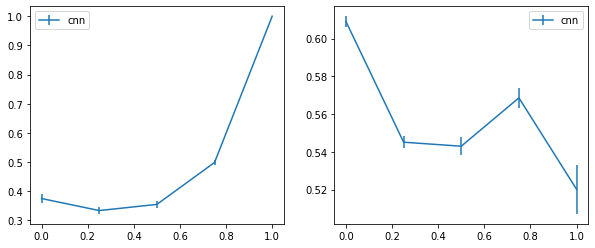

In [14]:
plot_corr_strength(3)

### Model Parameters

In [20]:
# Vbranch params
shared_frac_list = [0., 0.25, 0.5, 0.75, 1.]
num_branches = 2

vbranch_params = []
for frac in shared_frac_list:
    tf.reset_default_graph()
    inputs = tf.placeholder('float32', [None, 32,32,3])
    model = build_model(num_branches, frac, compile_loss=False)
    model.summary()
    vbranch_params.append(model.count_parameters())

i   Layer name                      Output shape        Num param  Inbound            
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [] [None,32,32,32]  1792       input              
                                    [] [None,32,32,32]                                
--------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [] [None,32,32,32]  128        conv2d_1_1         
                                    [] [None,32,32,32]                                
-------------------------------------------

i   Layer name                      Output shape                     Num param  Inbound            
---------------------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                                 
---------------------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                                 
---------------------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [None,32,32,16] [None,32,32,16]  1344       input              
                                    [None,32,32,16] [None,32,32,16]                                
---------------------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [None,32,32,16] [None,32,32,16]  96         conv2d_1_1         


i   Layer name                      Output shape        Num param  Inbound            
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [None,32,32,32] []  896        input              
                                    [None,32,32,32] []                                
--------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [None,32,32,32] []  64         conv2d_1_1         
                                    [None,32,32,32] []                                
-------------------------------------------

In [21]:
param_ratio = [p / vbranch_params[-1] for p in vbranch_params]
ideal_ratio = num_branches - np.array(shared_frac_list)**2 * (num_branches-1)

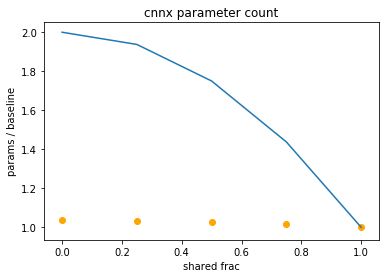

In [22]:
plt.scatter(shared_frac_list, param_ratio, color='orange')
# plt.plot(shared_frac_list, [1]*len(shared_frac_list))
plt.plot(shared_frac_list, ideal_ratio)

plt.xlabel('shared frac')
plt.ylabel('params / baseline')
plt.title('{} parameter count'.format(ARCHITECTURE))

plt.savefig('figs/cnn-small-parameter-count.png')
plt.show()